# Preliminaries

Dataset used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative, print_recourse_report_KStest_cumulative
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
from pathlib import Path

random_seed = 131313 # for reproducibility
precomputed_rules_file = Path("..") / "Pre-computed Results" / "Adult" / "rulesAdult_sex_atomic.data"
precomputed_rules_with_cumulative_file = Path("..") / "Pre-computed Results" / "Adult" / "rulesAdult_sex_cumulative.data"

## Load Dataset

In [3]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X, "adult")

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


## Model training and test

In [4]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_seed, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [5]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

CPU times: total: 3.8 s
Wall time: 4.08 s


array([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.])

In [6]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     10205
           1       0.73      0.62      0.67      3362

    accuracy                           0.85     13567
   macro avg       0.80      0.77      0.78     13567
weighted avg       0.84      0.85      0.84     13567



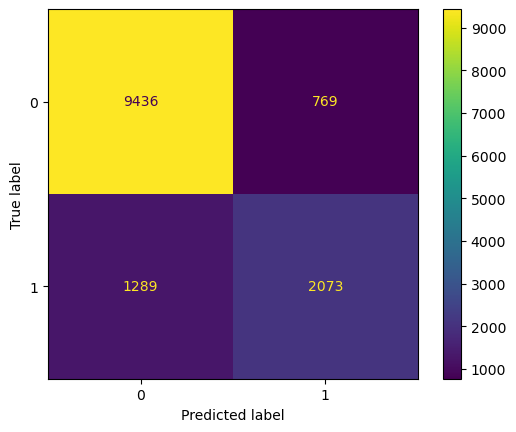

In [7]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Main Contribution

## Find all valid if-thens with all respective coverages and atomic correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [11]:
#Uncomment if you want to find new rules with different support

start_time = time.time()
ifthens_coverage_correctness, stats = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='sex',
    freqitem_minsupp = 0.01,
    missing_subgroup_val="Unknown",
    drop_infeasible = True,
    drop_above = True
)
end_time = time.time()

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.57it/s]

Number of frequent itemsets for affected: {' Female': 28176, ' Male': 27510}
Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|████████████████████████████████████████████████████████████████████████| 27510/27510 [00:00<00:00, 570175.64it/s]

Number of subgroups in the intersection: 13300


Number of frequent itemsets for the unaffected: 57008
Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|██████████████████████████████████████████████████████████████████████████| 13300/13300 [00:02<00:00, 5891.93it/s]


Computing correctenesses for all valid if-thens.


100%|████████████████████████████████████████████████████████████████████████████| 97413/97413 [20:30<00:00, 79.19it/s]


Number of if-thens: 97413


In [8]:
from facts.utils import load_rules_by_if, save_rules_by_if

## Use this for loading rules from disk
rules_by_if = load_rules_by_if(precomputed_rules_file)

## Use this for saving rules on disk
#save_rules_by_if(precomputed_rules_file, rules_by_if)

In [9]:
num_features = ['education-num', 'capital-gain', 'capital-loss']
cate_features = ['age', 'Workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ord_features = ['hours-per-week']

feature_weights = {"race" : 100 , "sex": 100, "marital-status": 5, "relationship":5, "age": 10, "occupation": 4, "Workclass": 2, "native-country": 4,
                    "hours-per-week":2, "capital-gain": 1, "capital-loss":1, "education-num": 3}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=True,
    feats_to_normalize = ["capital-gain", "capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

We continue with the rankings and selection of rules according to each of the proposed metrics.

In [10]:
stats["valid-if-thens-time"] = end_time - start_time
stats["triples-no"] = len(ifthens_coverage_correctness)
stats["subgroup-no"] = len(rules_by_if)

NameError: name 'end_time' is not defined

## Macro Viewpoint

### Equal Cost of Effectiveness (Macro)

In [11]:
start_time = time.time()

top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        "remove-fair-rules",
        "keep-only-min-change"
    ],
    cor_threshold=0.5,
    secondary_sorting_objectives=[
        # "min-group-cost",
        "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If age = (34.0, 41.0], capital-loss = 0, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 2.28% covered out of 6546
		Make age = (41.0, 50.0], capital-loss = 1902, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 84.97%.
		Aggregate cost of the above recourses = 20.44
	Protected Subgroup ' Female', 2.77% covered out of 4179
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 51.30%.
		Aggregate cost of the above recourses = 10.00
	Bias against  Male due to Equal Effectiveness. Unfairness score = 10.44.
If Workclass =  Private, age = (26.0, 34.0], hours-per-week = OverTime, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.37% covered out of 6546
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 68.48%.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relation

### Equal Choice for Recourse

In [12]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        # "remove-fair-rules"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If age = (26.0, 34.0], hours-per-week = FullTime, occupation =  Sales:
	Protected Subgroup ' Male', 1.07% covered out of 6546
		Make age = (41.0, 50.0], hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 45.83%.
		Make age = (34.0, 41.0], hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 44.44%.
		Make age = (41.0, 50.0], occupation =  Prof-specialty with effectiveness 43.06%.
		Make age = (41.0, 50.0], hours-per-week = OverTime, occupation =  Prof-specialty with effectiveness 45.83%.
		Make age = (41.0, 50.0], occupation =  Exec-managerial with effectiveness 44.44%.
		Make age = (34.0, 41.0], hours-per-week = OverTime, occupation =  Prof-specialty with effectiveness 43.06%.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with effectiveness 22.22%.
		Make age = (34.0, 41.0], occupation =  Exec-managerial with effectiveness 29.17%.
		Make age = (41.0, 50.0], hours-per-week = OverTime with effectiveness 43.06%.
		Make hours-per-w

## Micro viewpoint

We start by computing the cumulative effectiveness of the actions for each subgroup and each value of the protected attribute.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [15]:
start_time = time.time()
rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="sex", params=params)
end_time = time.time()

100%|████████████████████████████████████████████████████████████████████████████| 12556/12556 [10:20<00:00, 20.24it/s]


In [16]:
stats["cumulative-time"] = end_time - start_time

In [13]:
## Use this for loading rules from disk
rules_with_cumulative = load_rules_by_if(precomputed_rules_with_cumulative_file)

## Use this for saving rules on disk
# save_rules_by_if(precomputed_rules_with_cumulative_file, rules_with_cumulative)

# facts.update_costs_cumulative(rules_with_cumulative, params)

### Equal (Conditional) Mean Recourse

If native-country =  United-States, race =  Black, relationship =  Not-in-family:
	Protected Subgroup ' Male', 2.27% covered out of 6546
		Make relationship =  Married with effectiveness 2.65% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 2.65% and counterfactual cost = 100.0.
		Make race =  White, relationship =  Married with effectiveness 3.97% and counterfactual cost = 105.0.
		Aggregate cost of the above recourses = 38.33
	Protected Subgroup ' Female', 4.02% covered out of 4179
		Make relationship =  Married with effectiveness 0.00% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 0.00% and counterfactual cost = 100.0.
		Make race =  White, relationship =  Married with effectiveness 0.72% and counterfactual cost = 105.0.
		Aggregate cost of the above recourses = 105.00
	Bias against  Female due to Equal Effectiveness. Unfairness score = 66.667.
	Cumulative effectiveness plot for the above recourses:


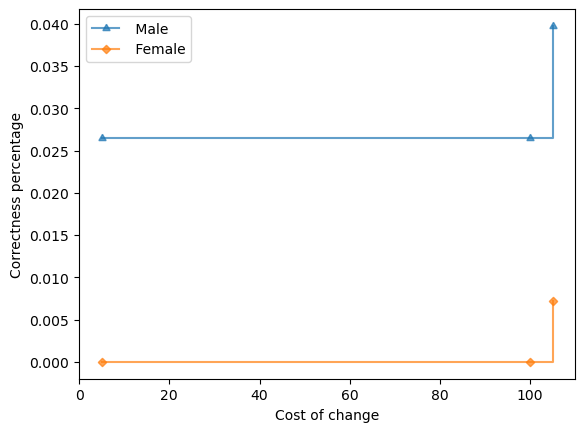

If age = (34.0, 41.0], race =  Black:
	Protected Subgroup ' Male', 1.36% covered out of 6546
		Make age = (41.0, 50.0] with effectiveness 2.02% and counterfactual cost = 10.0.
		Make race =  White with effectiveness 3.03% and counterfactual cost = 100.0.
		Make age = (50.0, 90.0], race =  White with effectiveness 4.04% and counterfactual cost = 110.0.
		Make age = (41.0, 50.0], race =  Asian-Pac-Islander with effectiveness 4.04% and counterfactual cost = 110.0.
		Make age = (41.0, 50.0], race =  White with effectiveness 5.05% and counterfactual cost = 110.0.
		Aggregate cost of the above recourses = 68.00
	Protected Subgroup ' Female', 3.13% covered out of 4179
		Make age = (41.0, 50.0] with effectiveness 0.86% and counterfactual cost = 10.0.
		Make race =  White with effectiveness 0.86% and counterfactual cost = 100.0.
		Make age = (41.0, 50.0], race =  White with effectiveness 0.86% and counterfactual cost = 110.0.
		Make age = (50.0, 90.0], race =  White with effectiveness 0.86% and

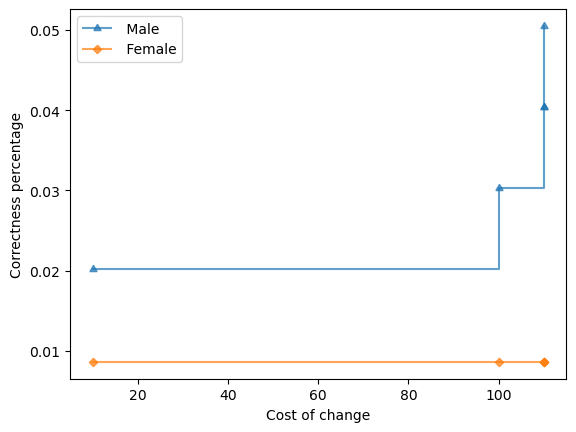

If age = (26.0, 34.0], race =  Black:
	Protected Subgroup ' Male', 2.02% covered out of 6546
		Make age = (41.0, 50.0] with effectiveness 3.40% and counterfactual cost = 10.0.
		Make race =  White with effectiveness 3.40% and counterfactual cost = 100.0.
		Make age = (34.0, 41.0], race =  White with effectiveness 4.76% and counterfactual cost = 110.0.
		Make age = (41.0, 50.0], race =  Asian-Pac-Islander with effectiveness 4.76% and counterfactual cost = 110.0.
		Make age = (41.0, 50.0], race =  White with effectiveness 7.48% and counterfactual cost = 110.0.
		Aggregate cost of the above recourses = 64.55
	Protected Subgroup ' Female', 3.46% covered out of 4179
		Make age = (41.0, 50.0] with effectiveness 2.65% and counterfactual cost = 10.0.
		Make race =  White with effectiveness 2.65% and counterfactual cost = 100.0.
		Make age = (34.0, 41.0], race =  White with effectiveness 2.65% and counterfactual cost = 110.0.
		Make age = (41.0, 50.0], race =  Asian-Pac-Islander with effectiven

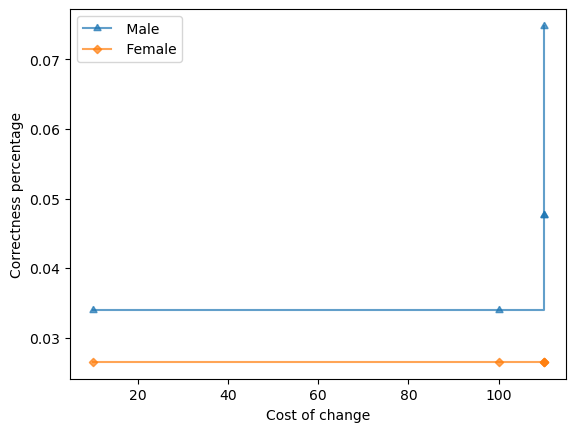

If occupation =  Other-service, race =  Black:
	Protected Subgroup ' Male', 1.40% covered out of 6546
		Make occupation =  Prof-specialty with effectiveness 4.04% and counterfactual cost = 4.0.
		Make occupation =  Craft-repair, race =  White with effectiveness 4.04% and counterfactual cost = 104.0.
		Make occupation =  Adm-clerical, race =  White with effectiveness 4.04% and counterfactual cost = 104.0.
		Make occupation =  Transport-moving, race =  White with effectiveness 4.04% and counterfactual cost = 104.0.
		Make occupation =  Sales, race =  White with effectiveness 5.05% and counterfactual cost = 104.0.
		Make occupation =  Prof-specialty, race =  Asian-Pac-Islander with effectiveness 5.05% and counterfactual cost = 104.0.
		Make occupation =  Protective-serv, race =  White with effectiveness 5.05% and counterfactual cost = 104.0.
		Make occupation =  Tech-support, race =  White with effectiveness 7.07% and counterfactual cost = 104.0.
		Make occupation =  Prof-specialty, race 

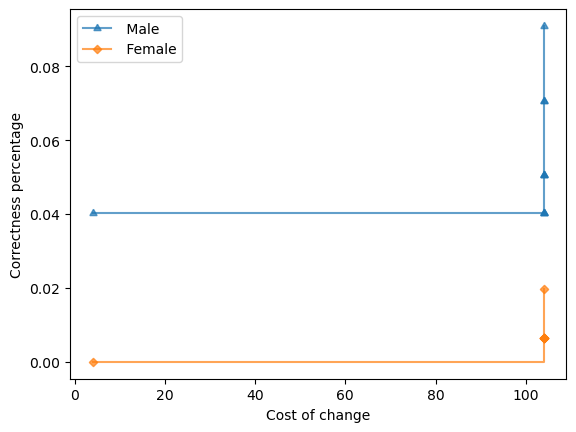

If hours-per-week = FullTime, native-country =  United-States, race =  Black, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.51% covered out of 6546
		Make relationship =  Married with effectiveness 2.04% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 2.04% and counterfactual cost = 100.0.
		Make hours-per-week = OverTime, race =  White with effectiveness 2.04% and counterfactual cost = 102.0.
		Make race =  White, relationship =  Married with effectiveness 3.06% and counterfactual cost = 105.0.
		Make hours-per-week = MidTime, race =  White, relationship =  Married with effectiveness 3.06% and counterfactual cost = 107.0.
		Make hours-per-week = OverTime, race =  White, relationship =  Married with effectiveness 4.08% and counterfactual cost = 107.0.
		Make hours-per-week = PartTime, race =  White, relationship =  Married with effectiveness 4.08% and counterfactual cost = 109.0.
		Make hours-per-week = BrainDrain, race =  White, relationship =  M

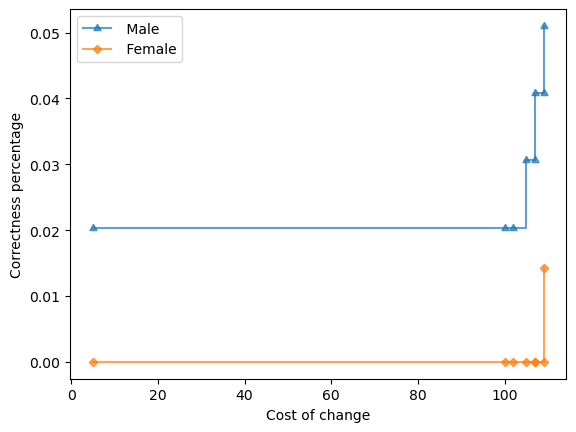

If marital-status =  Never-married, race =  Black, relationship =  Own-child:
	Protected Subgroup ' Male', 1.54% covered out of 6546
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 1.75% and counterfactual cost = 10.0.
		Make race =  White, relationship =  Not-in-family with effectiveness 1.75% and counterfactual cost = 105.0.
		Make marital-status =  Divorced, race =  White, relationship =  Not-in-family with effectiveness 1.75% and counterfactual cost = 110.0.
		Make marital-status =  Married-civ-spouse, race =  White, relationship =  Married with effectiveness 2.63% and counterfactual cost = 110.0.
		Make marital-status =  Married-civ-spouse, race =  Asian-Pac-Islander, relationship =  Married with effectiveness 2.63% and counterfactual cost = 110.0.
		Aggregate cost of the above recourses = 43.33
	Protected Subgroup ' Female', 2.02% covered out of 4179
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 1.4

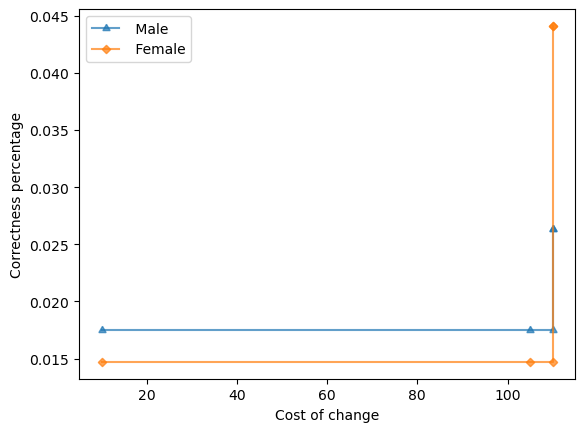

In [14]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness

If Workclass =  Private, age = (34.0, 41.0], capital-loss = 0, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 1.19% covered (protected subgroup population size not given)
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 37.04% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 40.74% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 56.79% and counterfactual cost = 6.0.
		Make age = (50.0, 90.0] with effectiveness 56.79% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 56.79% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with effectiveness 56.79% and counterfactual cost = 14.0.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with effectiveness 56.79% and counterfactual cost = 14.0.


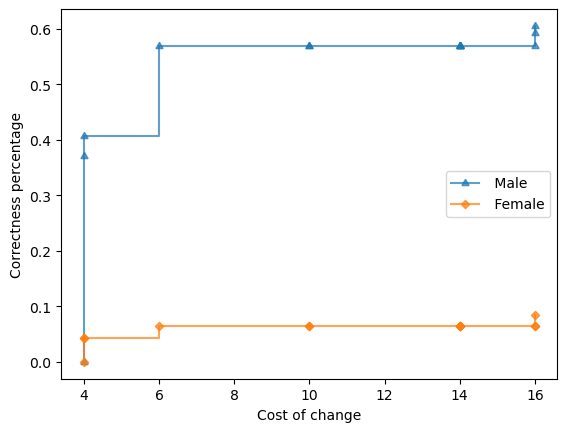

If Workclass =  Private, age = (34.0, 41.0], capital-gain = 0, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 1.22% covered (protected subgroup population size not given)
		Make occupation =  Prof-specialty with effectiveness 37.35% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 40.96% and counterfactual cost = 4.0.
		Make Workclass =  Local-gov, occupation =  Prof-specialty with effectiveness 40.96% and counterfactual cost = 6.0.
		Make age = (50.0, 90.0] with effectiveness 40.96% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 40.96% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with effectiveness 40.96% and counterfactual cost = 14.0.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with effectiveness 40.96% and counterfactual cost = 14.0.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with effectiveness 40.96% and counterf

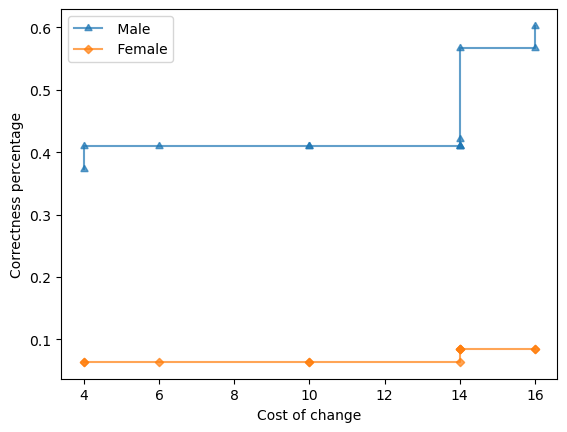

If Workclass =  Private, age = (34.0, 41.0], capital-loss = 0, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 1.16% covered (protected subgroup population size not given)
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 40.26% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 44.16% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 59.74% and counterfactual cost = 6.0.
		Make age = (50.0, 90.0] with effectiveness 59.74% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 59.74% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with effectiveness 59.74% and counterfactual cost = 14.0.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with effectiveness 59.74% and counterfactual cost = 14.0.
		Make age = (50.0

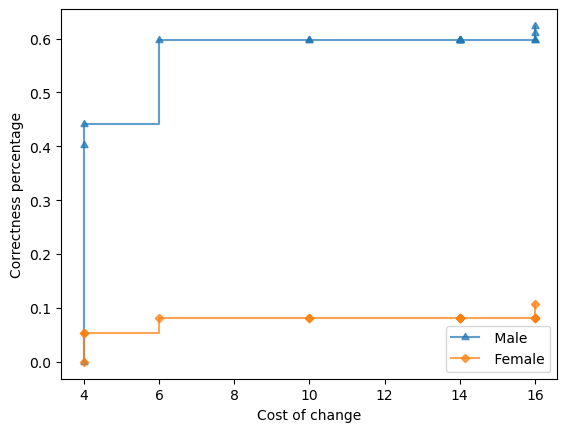

If Workclass =  Private, age = (26.0, 34.0], capital-gain = 0, capital-loss = 0, native-country =  United-States, occupation =  Exec-managerial, race =  White:
	Protected Subgroup ' Male', 1.06% covered (protected subgroup population size not given)
		Make occupation =  Prof-specialty with effectiveness 0.00% and counterfactual cost = 4.0.
		Make age = (34.0, 41.0] with effectiveness 42.47% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 50.68% and counterfactual cost = 10.0.
		Make age = (34.0, 41.0], occupation =  Sales with effectiveness 50.68% and counterfactual cost = 14.0.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with effectiveness 50.68% and counterfactual cost = 14.0.
		Make age = (41.0, 50.0], occupation =  Sales with effectiveness 50.68% and counterfactual cost = 14.0.
		Make age = (41.0, 50.0], occupation =  Prof-specialty with effectiveness 50.68% and counterfactual cost = 14.0.
		Make Workclass =  Local-gov, age = (41.0, 50.0], o

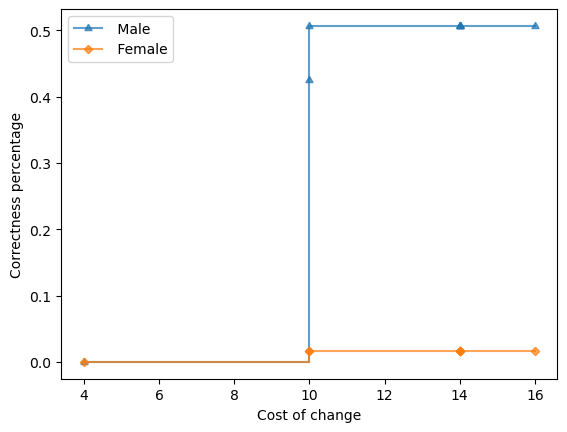

If age = (34.0, 41.0], capital-loss = 0, native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 1.42% covered (protected subgroup population size not given)
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 35.23% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 39.77% and counterfactual cost = 4.0.
		Make age = (50.0, 90.0] with effectiveness 39.77% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 39.77% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with effectiveness 39.77% and counterfactual cost = 14.0.
		Make age = (41.0, 50.0], occupation =  Adm-clerical with effectiveness 39.77% and counterfactual cost = 14.0.
		Make age = (50.0, 90.0], occupation =  Craft-repair with effectiveness 39.77% and counterfactual cost = 14.0.
		Make age = (50.0,

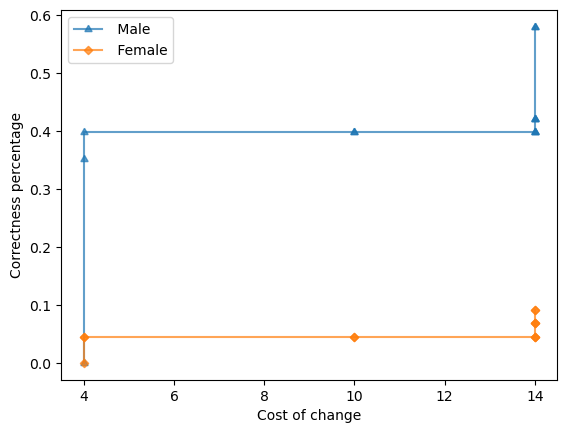

If Workclass =  Private, age = (41.0, 50.0], capital-loss = 0, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 1.60% covered (protected subgroup population size not given)
		Make occupation =  Craft-repair with effectiveness 6.25% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 13.54% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 28.12% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 51.04% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-not-inc, occupation =  Prof-specialty with effectiveness 51.04% and counterfactual cost = 6.0.
		Make Workclass =  Local-gov, occupation =  Prof-specialty with effectiveness 51.04% and counterfactual cost = 6.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 56.25% and counterfactual cost = 6.0.
		Make age = (50.0, 90.0], occupation =  Sales with effectiveness 56.25% and counterfactual

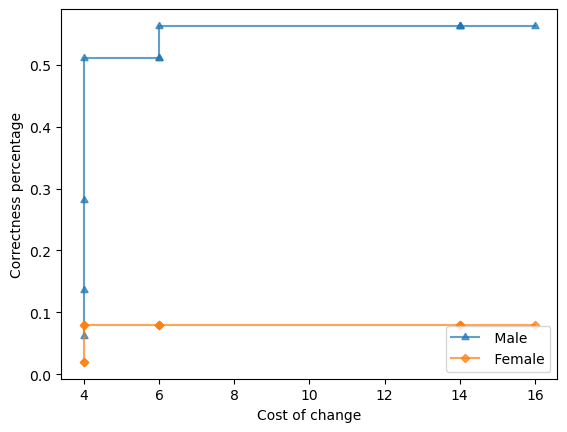

If Workclass =  Private, capital-loss = 0, education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 2.39% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 15.53% and counterfactual cost = 3.0.
		Make occupation =  Craft-repair with effectiveness 15.53% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 27.95% and counterfactual cost = 4.0.
		Make education-num = 10, occupation =  Prof-specialty with effectiveness 32.92% and counterfactual cost = 7.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 42.24% and counterfactual cost = 7.0.
		Make Workclass =  Self-emp-inc, education-num = 10, occupation =  Exec-managerial with effectiveness 50.93% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.51
	Protected Subgroup ' Female', 3.51% covered (protected subgroup population size not given)
		Make education-num = 10 with effect

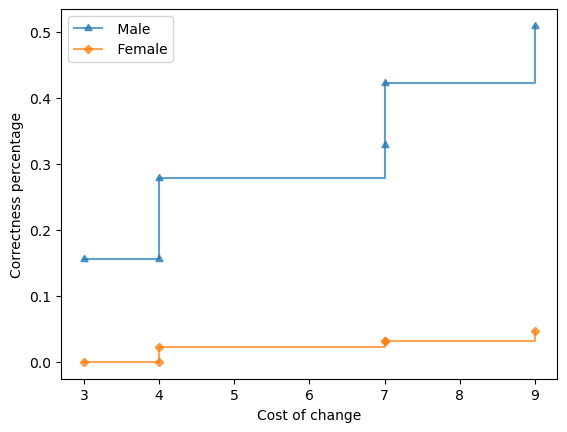

If age = (26.0, 34.0], capital-gain = 0, capital-loss = 0, native-country =  United-States, occupation =  Exec-managerial, race =  White:
	Protected Subgroup ' Male', 1.34% covered (protected subgroup population size not given)
		Make occupation =  Prof-specialty with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 0.00% and counterfactual cost = 4.0.
		Make age = (34.0, 41.0] with effectiveness 39.78% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 47.31% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with effectiveness 47.31% and counterfactual cost = 14.0.
		Make age = (34.0, 41.0], occupation =  Sales with effectiveness 47.31% and counterfactual cost = 14.0.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with effectiveness 47.31% and counterfactual cost = 14.0.
		Make age = (41.0, 50.0], occupation =  Sales with effectiveness 47.31% and counterfactual cost =

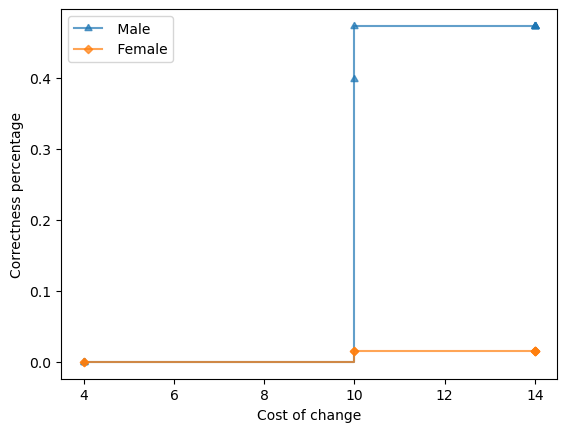

If age = (34.0, 41.0], capital-loss = 0, education-num = 10, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 3.19% covered (protected subgroup population size not given)
		Make education-num = 11 with effectiveness 15.62% and counterfactual cost = 3.0.
		Make education-num = 12 with effectiveness 29.69% and counterfactual cost = 6.0.
		Make age = (50.0, 90.0] with effectiveness 29.69% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 29.69% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], education-num = 11 with effectiveness 29.69% and counterfactual cost = 13.0.
		Make age = (41.0, 50.0], education-num = 12 with effectiveness 53.12% and counterfactual cost = 16.0.
		Aggregate cost of the above recourses = 0.53
	Protected Subgroup ' Female', 2.62% covered (protected subgroup population size not given)
		Make education-num = 11 with effectiveness 0.95% and counterfactual cost = 3.0.
		Make education-num = 12 with effecti

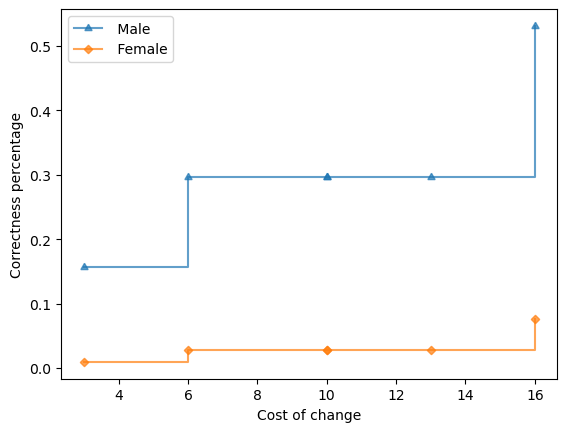

If Workclass =  Private, education-num = 9, native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 2.39% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 14.47% and counterfactual cost = 3.0.
		Make occupation =  Craft-repair with effectiveness 14.47% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 26.42% and counterfactual cost = 4.0.
		Make education-num = 10, occupation =  Prof-specialty with effectiveness 31.45% and counterfactual cost = 7.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 40.88% and counterfactual cost = 7.0.
		Make Workclass =  Self-emp-inc, education-num = 10, occupation =  Exec-managerial with effectiveness 49.69% and counterfactual cost = 9.0.
		Make education-num = 11, occupation =  Exec-managerial with effectiveness 49.69% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.50

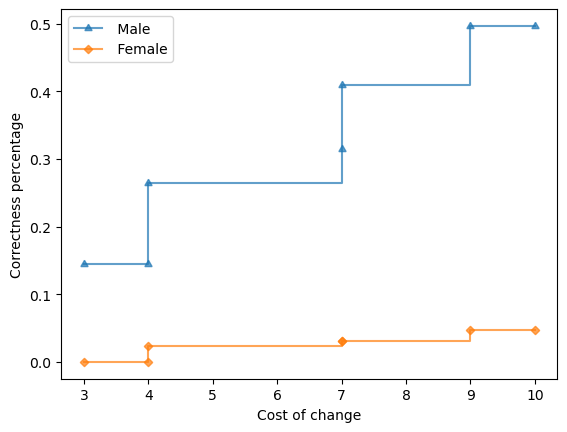

In [15]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric= True
)

### Equal Cost of Effectiveness (micro)

If Workclass =  Private, age = (34.0, 41.0], marital-status =  Married-civ-spouse:
	Protected Subgroup ' Male', 7.64% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 11.02% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 24.65% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0] with effectiveness 24.65% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 24.65% and counterfactual cost = 10.0.
		Make Workclass =  Self-emp-not-inc, age = (41.0, 50.0] with effectiveness 24.65% and counterfactual cost = 12.0.
		Make Workclass =  Self-emp-not-inc, age = (50.0, 90.0] with effectiveness 24.65% and counterfactual cost = 12.0.
		Make Workclass =  Local-gov, age = (50.0, 90.0] with effectiveness 24

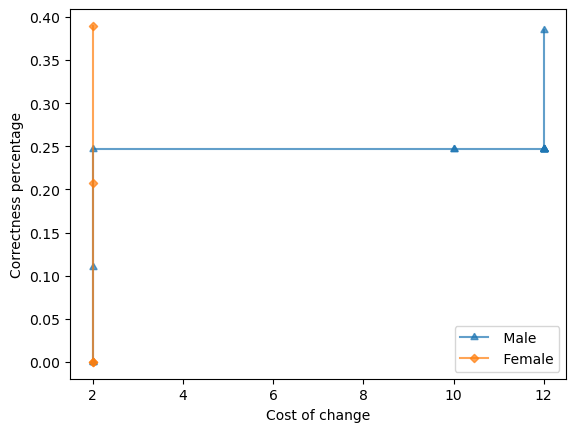

If Workclass =  Private, age = (34.0, 41.0], relationship =  Married:
	Protected Subgroup ' Male', 7.60% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 11.09% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 24.80% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0] with effectiveness 24.80% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 24.80% and counterfactual cost = 10.0.
		Make Workclass =  Self-emp-not-inc, age = (41.0, 50.0] with effectiveness 24.80% and counterfactual cost = 12.0.
		Make Workclass =  Self-emp-not-inc, age = (50.0, 90.0] with effectiveness 24.80% and counterfactual cost = 12.0.
		Make Workclass =  Local-gov, age = (50.0, 90.0] with effectiveness 24.80% and coun

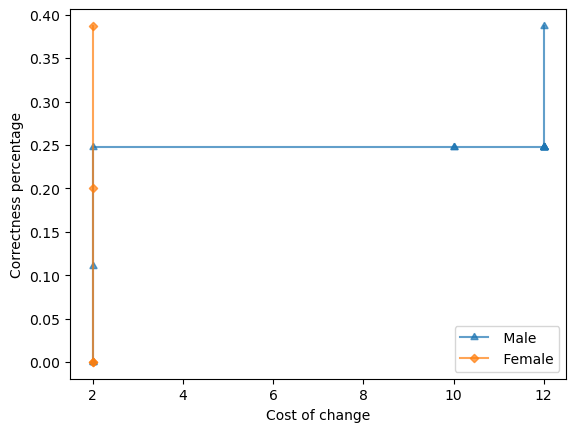

If Workclass =  Private, age = (26.0, 34.0], marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 4.72% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 31.68% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup ' Female', 4.57% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 28.88% and counterfactual cost = 10.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 43.85% and counterfactual cost = 20.0.
		Aggregate cost of the above recourses = 20.00
	Bias against  Female due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


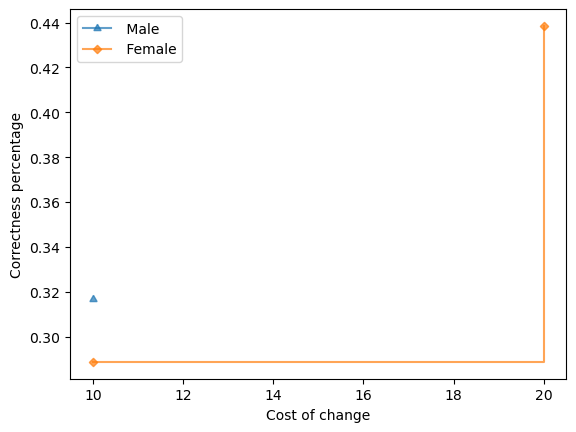

If Workclass =  Private, age = (34.0, 41.0], marital-status =  Never-married, race =  White:
	Protected Subgroup ' Male', 2.10% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse with effectiveness 12.94% and counterfactual cost = 5.0.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse with effectiveness 12.94% and counterfactual cost = 7.0.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse with effectiveness 12.94% and counterfactual cost = 7.0.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse with effectiveness 17.06% and counterfactual cost = 7.0.
		Make Workclass =  Federal-gov, marital-status =  Married-civ-spouse with effectiveness 21.18% and counterfactual cost = 7.0.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse with effectiveness 21.18% and counterfactual cost = 15.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse with effectiveness

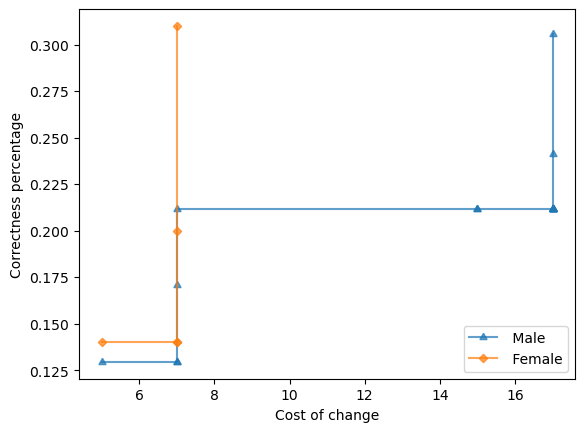

If age = (34.0, 41.0], capital-loss = 0, marital-status =  Divorced, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.82% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 29.06% and counterfactual cost = 10.0.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 29.91% and counterfactual cost = 20.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 34.19% and counterfactual cost = 20.0.
		Aggregate cost of the above recourses = 20.00
	Protected Subgroup ' Female', 2.04% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 36.78% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Bias against  Male due to Equal Effectiveness. Unfairness score = 10.0.
	

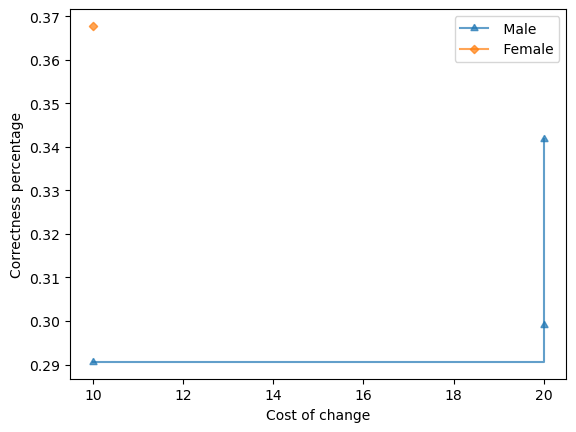

In [16]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        # "keep-only-min-change",
        
    ],
    cor_threshold = 0.3,
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness Within Budget

If Workclass =  Private, age = (34.0, 41.0], capital-loss = 0, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 1.16% covered (protected subgroup population size not given)
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 40.26% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 44.16% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 59.74% and counterfactual cost = 6.0.
		Make age = (50.0, 90.0] with effectiveness 59.74% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 59.74% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.60
	Protected Subgroup ' Female', 1.06% covered (protected subgroup population size not given)
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupatio

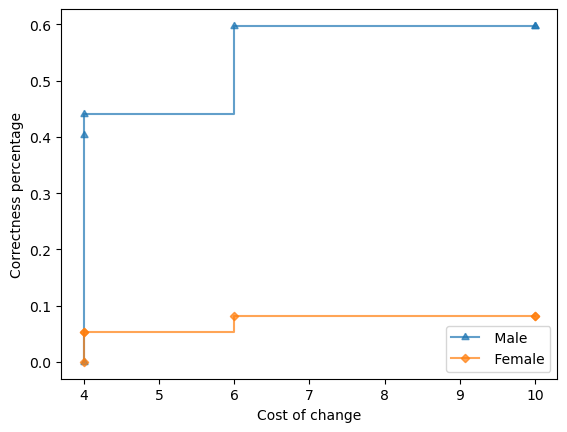

If Workclass =  Private, age = (26.0, 34.0], capital-gain = 0, capital-loss = 0, native-country =  United-States, occupation =  Exec-managerial, race =  White:
	Protected Subgroup ' Male', 1.06% covered (protected subgroup population size not given)
		Make occupation =  Prof-specialty with effectiveness 0.00% and counterfactual cost = 4.0.
		Make age = (34.0, 41.0] with effectiveness 42.47% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 50.68% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.51
	Protected Subgroup ' Female', 1.47% covered (protected subgroup population size not given)
		Make occupation =  Prof-specialty with effectiveness 0.00% and counterfactual cost = 4.0.
		Make age = (34.0, 41.0] with effectiveness 1.64% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 1.64% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.02
	Bias against  Female due to Equal Effectivene

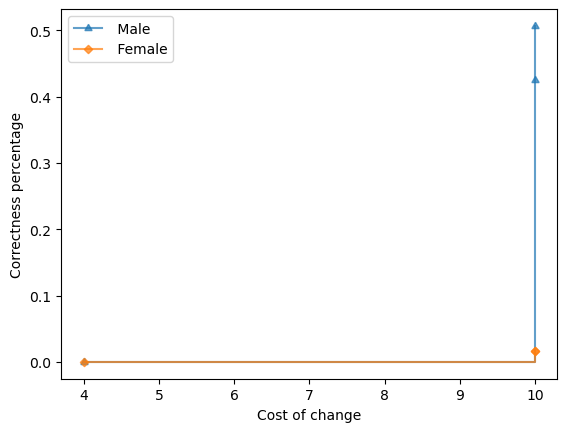

If Workclass =  Private, age = (41.0, 50.0], capital-loss = 0, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 1.60% covered (protected subgroup population size not given)
		Make occupation =  Craft-repair with effectiveness 6.25% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 13.54% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 28.12% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 51.04% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-not-inc, occupation =  Prof-specialty with effectiveness 51.04% and counterfactual cost = 6.0.
		Make Workclass =  Local-gov, occupation =  Prof-specialty with effectiveness 51.04% and counterfactual cost = 6.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 56.25% and counterfactual cost = 6.0.
		Aggregate cost of the above recourses = 0.56
	Protected Subgroup ' Female', 1.01% covered

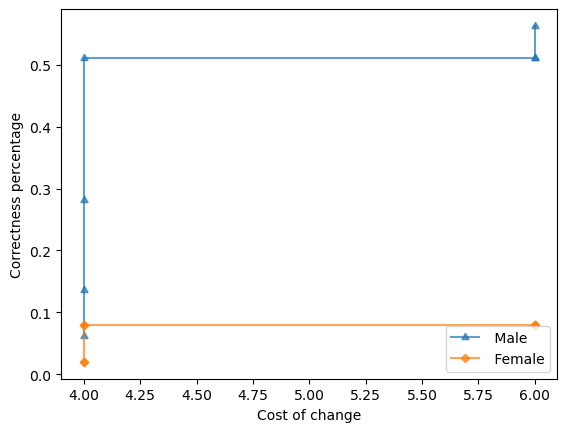

If Workclass =  Private, capital-loss = 0, education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 2.39% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 15.53% and counterfactual cost = 3.0.
		Make occupation =  Craft-repair with effectiveness 15.53% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 27.95% and counterfactual cost = 4.0.
		Make education-num = 10, occupation =  Prof-specialty with effectiveness 32.92% and counterfactual cost = 7.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 42.24% and counterfactual cost = 7.0.
		Make Workclass =  Self-emp-inc, education-num = 10, occupation =  Exec-managerial with effectiveness 50.93% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.51
	Protected Subgroup ' Female', 3.51% covered (protected subgroup population size not given)
		Make education-num = 10 with effect

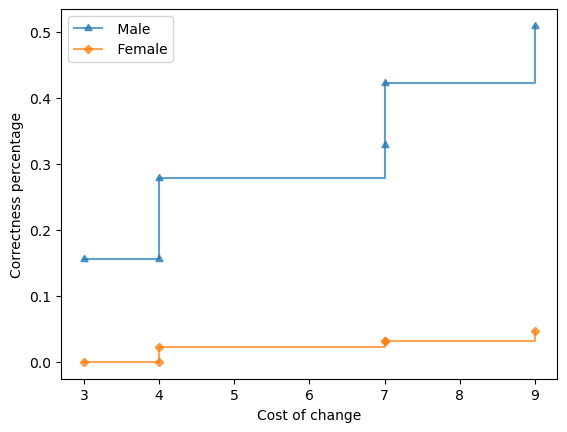

If age = (26.0, 34.0], capital-gain = 0, capital-loss = 0, native-country =  United-States, occupation =  Exec-managerial, race =  White:
	Protected Subgroup ' Male', 1.34% covered (protected subgroup population size not given)
		Make occupation =  Prof-specialty with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 0.00% and counterfactual cost = 4.0.
		Make age = (34.0, 41.0] with effectiveness 39.78% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 47.31% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.47
	Protected Subgroup ' Female', 1.56% covered (protected subgroup population size not given)
		Make occupation =  Prof-specialty with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 0.00% and counterfactual cost = 4.0.
		Make age = (34.0, 41.0] with effectiveness 1.47% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with e

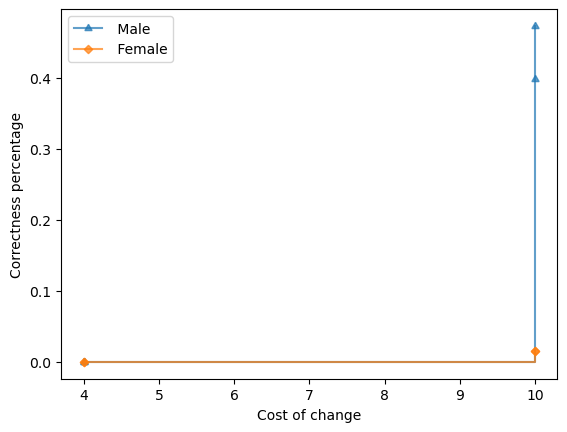

If Workclass =  Private, education-num = 9, native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 2.39% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 14.47% and counterfactual cost = 3.0.
		Make occupation =  Craft-repair with effectiveness 14.47% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 26.42% and counterfactual cost = 4.0.
		Make education-num = 10, occupation =  Prof-specialty with effectiveness 31.45% and counterfactual cost = 7.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 40.88% and counterfactual cost = 7.0.
		Make Workclass =  Self-emp-inc, education-num = 10, occupation =  Exec-managerial with effectiveness 49.69% and counterfactual cost = 9.0.
		Make education-num = 11, occupation =  Exec-managerial with effectiveness 49.69% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.50

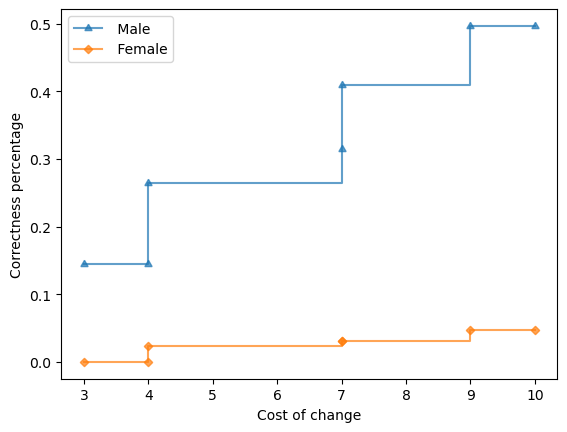

If capital-loss = 0, education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 3.13% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 12.98% and counterfactual cost = 3.0.
		Make occupation =  Craft-repair with effectiveness 12.98% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 23.56% and counterfactual cost = 4.0.
		Make education-num = 10, occupation =  Prof-specialty with effectiveness 31.73% and counterfactual cost = 7.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 42.31% and counterfactual cost = 7.0.
		Make education-num = 11, occupation =  Exec-managerial with effectiveness 49.52% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup ' Female', 3.80% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 0.00% and counterfactual cost = 3.0.
		M

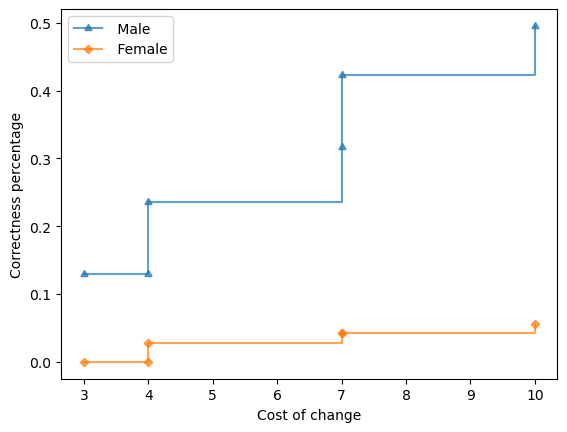

If age = (41.0, 50.0], capital-loss = 0, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 1.67% covered (protected subgroup population size not given)
		Make occupation =  Craft-repair with effectiveness 5.94% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical with effectiveness 6.93% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 14.85% and counterfactual cost = 4.0.
		Make occupation =  Tech-support with effectiveness 26.73% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 28.71% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 51.49% and counterfactual cost = 4.0.
		Aggregate cost of the above recourses = 0.51
	Protected Subgroup ' Female', 1.03% covered (protected subgroup population size not given)
		Make occupation =  Sales with effectiveness 1.96% and counterfactual cost = 4.0.
		Make occupation =  Craft-repair with effectiveness 1.96% and counterfa

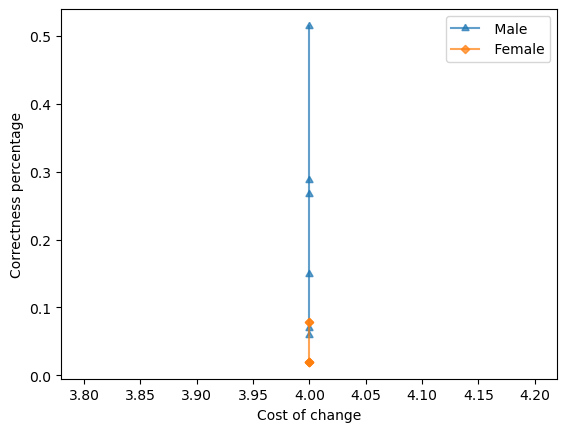

If Workclass =  Private, age = (50.0, 90.0], occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 1.06% covered (protected subgroup population size not given)
		Make Workclass =  Self-emp-inc with effectiveness 28.99% and counterfactual cost = 2.0.
		Make occupation =  Prof-specialty with effectiveness 28.99% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 33.33% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 44.93% and counterfactual cost = 6.0.
		Aggregate cost of the above recourses = 0.45
	Protected Subgroup ' Female', 1.42% covered (protected subgroup population size not given)
		Make Workclass =  Self-emp-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make occupation =  Exec-managerial with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 0.00% and counterfactual cost = 4.0.
		Make Workclass =

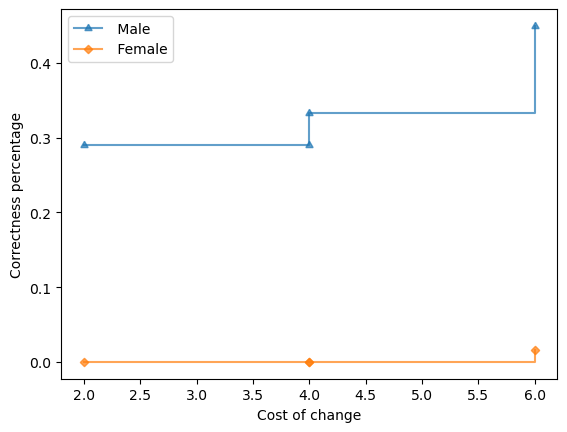

In [17]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
        #"remove-below-thr",
        #"keep-only-min-change",
        
    ],
    cost_threshold = 10,
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric = True
)

### Fair Effectiveness-Cost Trade-Off

If capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Male', 94.15% covered (protected subgroup population size not given)
		Make capital-gain = 5013 with effectiveness 38.94% and counterfactual cost = 0.05.
		Make capital-gain = 5178 with effectiveness 39.87% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 51.62% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 53.23% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 83.51% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 83.51% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 83.51% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 83.51% and counterfactual cost = 0.51.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' Female', 93.84% covered (protected subgroup population size not given)
		Make cap

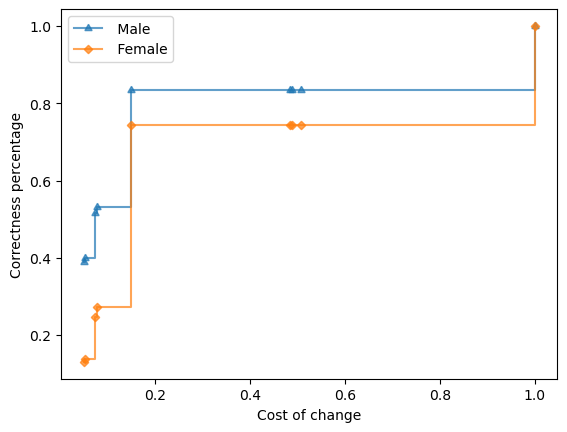

If capital-gain = 0:
	Protected Subgroup ' Male', 96.82% covered (protected subgroup population size not given)
		Make capital-gain = 5013 with effectiveness 39.39% and counterfactual cost = 0.05.
		Make capital-gain = 5178 with effectiveness 40.31% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 52.04% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 53.68% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 83.77% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' Female', 96.42% covered (protected subgroup population size not given)
		Make capital-gain = 5013 with effectiveness 13.80% and counterfactual cost = 0.05.
		Make capital-gain = 5178 with effectiveness 14.65% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 25.57% and counterfactual cost = 0.07.
		Make capital-gain = 7688 w

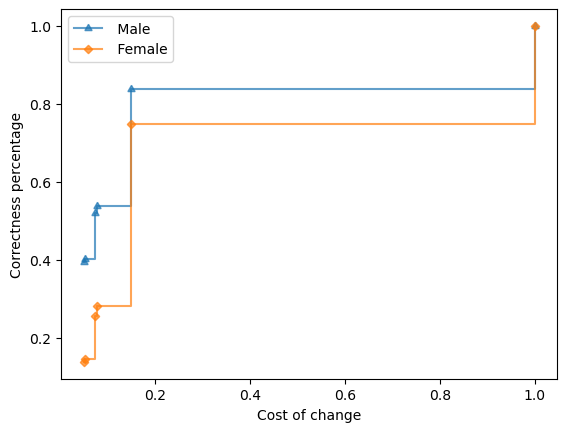

If capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 85.16% covered (protected subgroup population size not given)
		Make capital-gain = 5178 with effectiveness 40.96% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 52.92% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 54.59% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 84.27% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 84.27% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 84.27% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 84.27% and counterfactual cost = 0.51.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' Female', 85.81% covered (protected subgroup population size not given)
		Make capital-gain = 5178 with effectiveness 14.25% and count

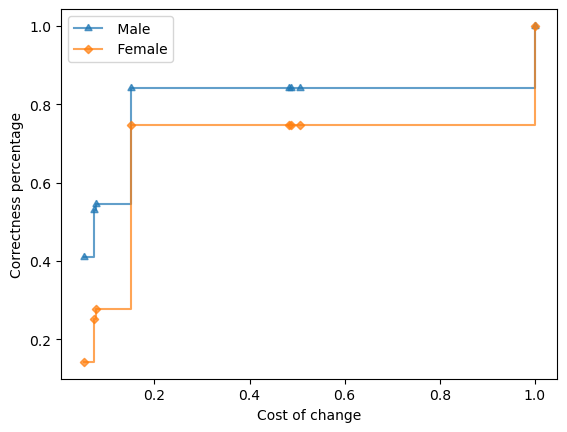

If capital-gain = 0, native-country =  United-States:
	Protected Subgroup ' Male', 87.60% covered (protected subgroup population size not given)
		Make capital-gain = 5178 with effectiveness 41.36% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 53.30% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 54.99% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 84.50% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' Female', 88.26% covered (protected subgroup population size not given)
		Make capital-gain = 5178 with effectiveness 15.16% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 26.16% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 28.91% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 75.26% and counterfactual cost = 

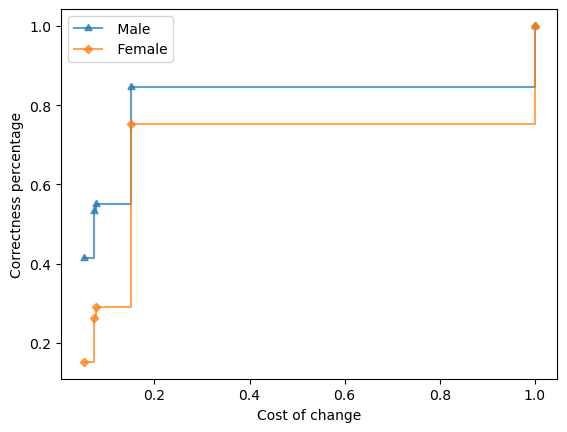

If capital-gain = 0, capital-loss = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 76.01% covered (protected subgroup population size not given)
		Make capital-gain = 5178 with effectiveness 43.12% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 55.04% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 56.71% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 85.43% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 85.43% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 85.43% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 85.43% and counterfactual cost = 0.51.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make race =  Black with effectiveness 100.00% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 69.40% covered (protected su

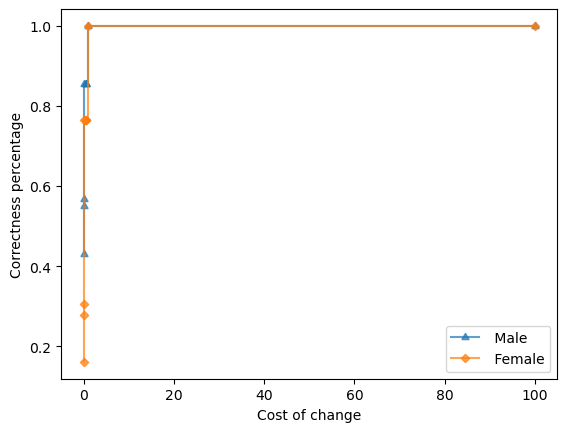

If capital-gain = 0, capital-loss = 0, race =  White:
	Protected Subgroup ' Male', 82.04% covered (protected subgroup population size not given)
		Make capital-gain = 5013 with effectiveness 40.88% and counterfactual cost = 0.05.
		Make capital-gain = 5178 with effectiveness 41.82% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 53.54% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 55.17% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 84.47% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 84.47% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 84.47% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 84.47% and counterfactual cost = 0.51.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make race =  Asian-Pac-Islander with effectiveness 100.00% and counterfactual cost = 1

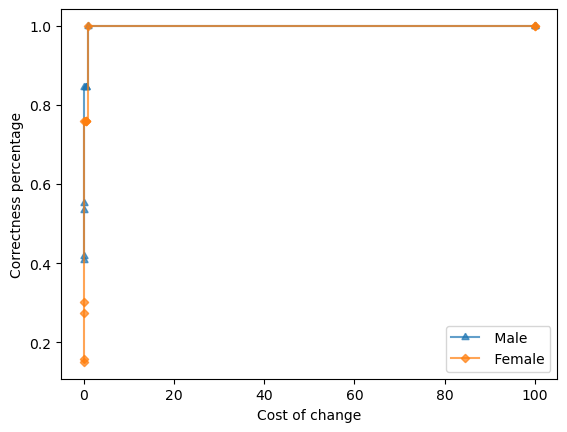

If Workclass =  Private, capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Male', 70.41% covered (protected subgroup population size not given)
		Make capital-gain = 5178 with effectiveness 36.86% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 47.63% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 49.31% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 80.73% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 80.73% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 80.73% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 80.73% and counterfactual cost = 0.51.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfac

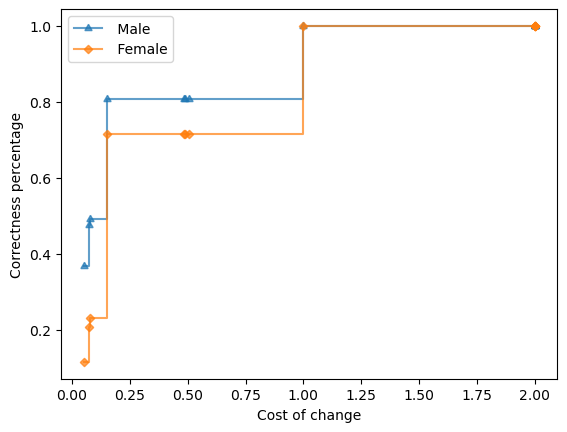

If Workclass =  Private, capital-gain = 0:
	Protected Subgroup ' Male', 72.26% covered (protected subgroup population size not given)
		Make capital-gain = 5178 with effectiveness 37.36% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 48.16% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 49.85% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 81.03% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 100.00% and counterfactual

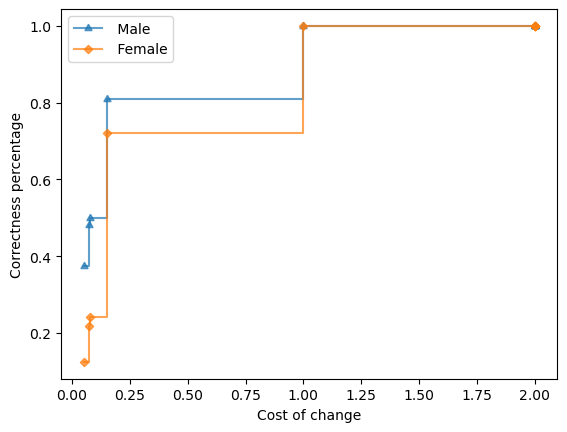

If capital-gain = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 78.22% covered (protected subgroup population size not given)
		Make capital-gain = 5178 with effectiveness 43.50% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 55.40% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 57.09% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 85.64% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make race =  Black with effectiveness 100.00% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 71.54% covered (protected subgroup population size not given)
		Make capital-gain = 5178 with effectiveness 17.14% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 28.95% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 31.77% and counterfactu

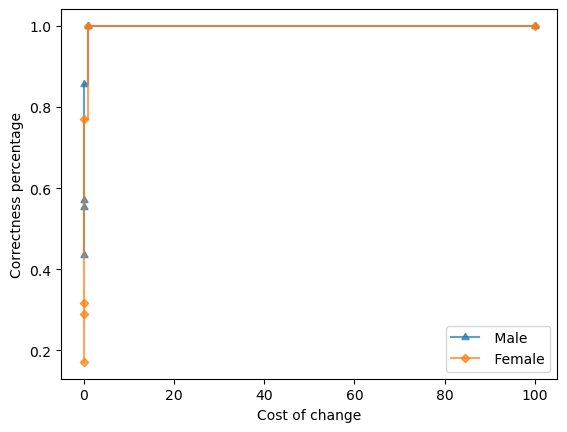

If capital-gain = 0, race =  White:
	Protected Subgroup ' Male', 84.37% covered (protected subgroup population size not given)
		Make capital-gain = 5013 with effectiveness 41.30% and counterfactual cost = 0.05.
		Make capital-gain = 5178 with effectiveness 42.23% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 53.95% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 55.60% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 84.71% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make race =  Asian-Pac-Islander with effectiveness 100.00% and counterfactual cost = 100.0.
		Make race =  Black with effectiveness 100.00% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 76.74% covered (protected subgroup population size not given)
		Make capital-gain = 5013 with effectiveness 15.89% and counterfactual cost = 0.05.
		Make c

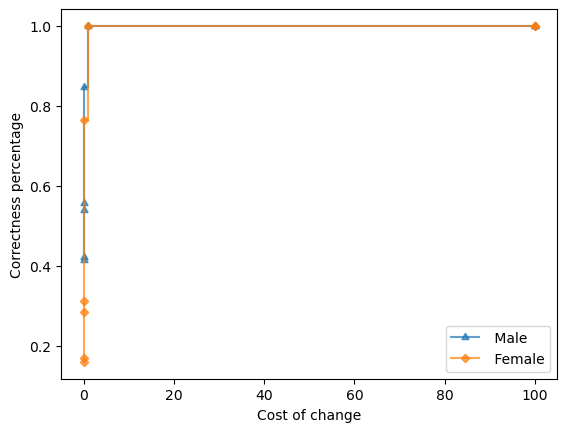

If Workclass =  Private, capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 62.89% covered (protected subgroup population size not given)
		Make capital-gain = 5178 with effectiveness 38.14% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 49.10% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 50.83% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 81.61% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 81.61% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 81.61% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 81.61% and counterfactual cost = 0.51.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with eff

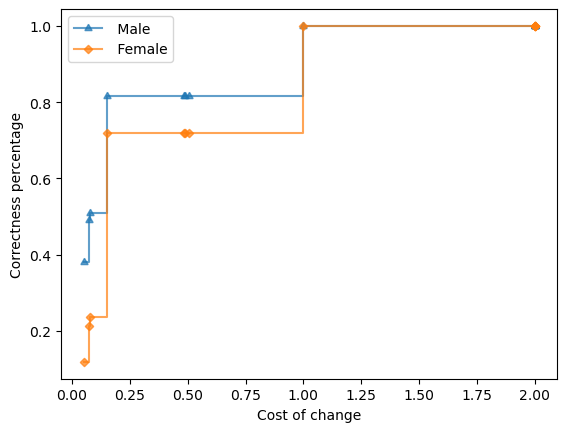

If Workclass =  Private, capital-gain = 0, native-country =  United-States:
	Protected Subgroup ' Male', 64.55% covered (protected subgroup population size not given)
		Make capital-gain = 5178 with effectiveness 38.61% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 49.57% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 51.31% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 81.86% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effecti

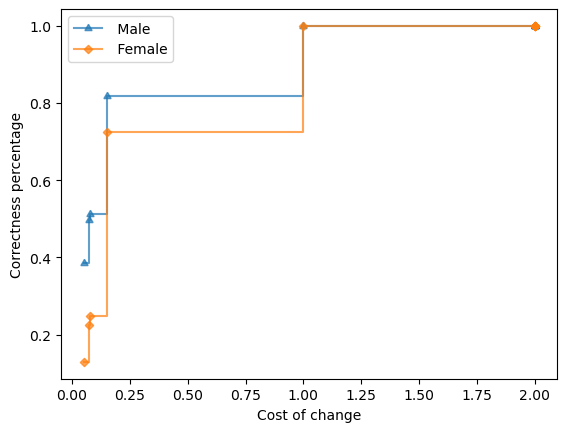

If Workclass =  Private, capital-gain = 0, capital-loss = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 55.93% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 51.33% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 53.09% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 82.91% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 82.91% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 82.91% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 82.91% and counterfactual cost = 0.51.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  

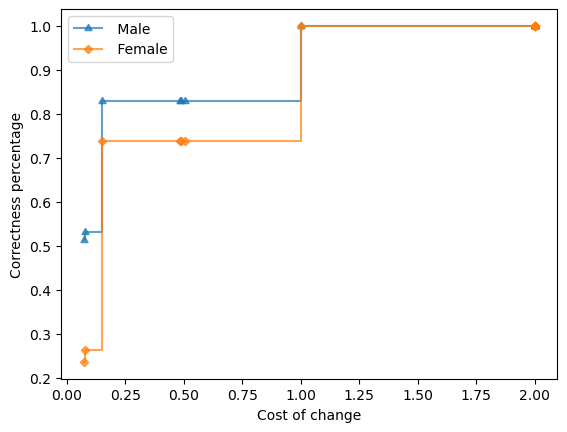

If capital-loss = 0:
	Protected Subgroup ' Male', 97.33% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 28.33% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 28.53% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 29.87% and counterfactual cost = 0.51.
	Protected Subgroup ' Female', 97.43% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 8.65% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 8.75% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 9.20% and counterfactual cost = 0.51.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 10.3.
	Cumulative effectiveness plot for the above recourses:


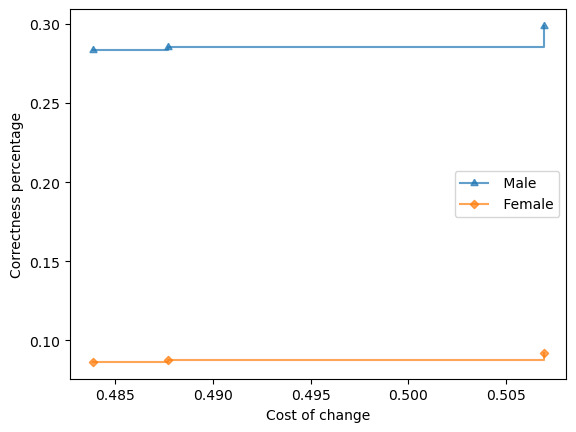

If Workclass =  Private, capital-gain = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 57.43% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 51.79% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 53.56% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 83.16% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 100.00% and counterfactual cost = 2.0.
	Protected Subgroup ' Fe

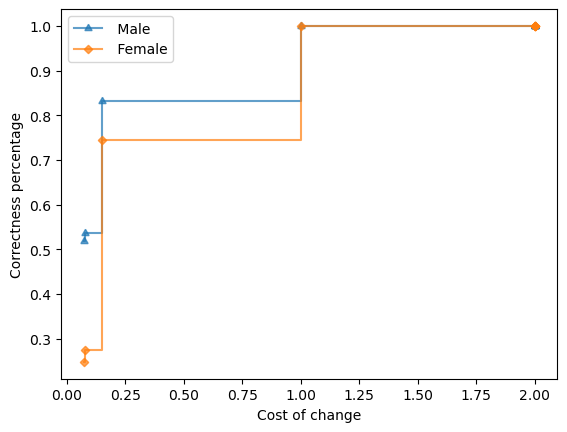

If Workclass =  Private, capital-gain = 0, capital-loss = 0, race =  White:
	Protected Subgroup ' Male', 61.14% covered (protected subgroup population size not given)
		Make capital-gain = 5178 with effectiveness 38.93% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 49.62% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 51.34% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 81.78% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 81.78% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 81.78% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 81.78% and counterfactual cost = 0.51.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00%

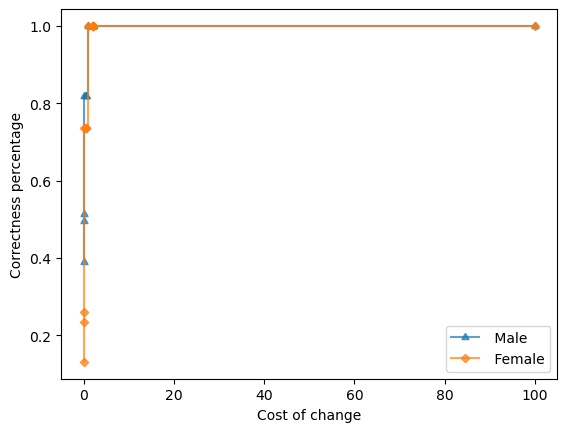

If Workclass =  Private, capital-gain = 0, race =  White:
	Protected Subgroup ' Male', 62.73% covered (protected subgroup population size not given)
		Make capital-gain = 5178 with effectiveness 39.38% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 50.10% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 51.85% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 82.07% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 100.00% and

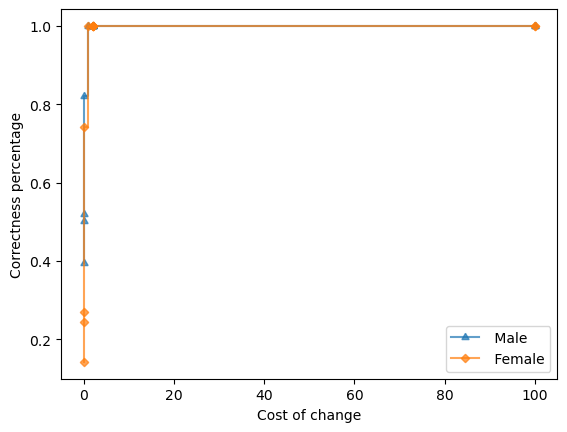

If capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 88.01% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 29.33% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 29.48% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 30.80% and counterfactual cost = 0.51.
	Protected Subgroup ' Female', 89.15% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 8.91% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 9.02% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 9.49% and counterfactual cost = 0.51.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 10.14.
	Cumulative effectiveness plot for the above recourses:


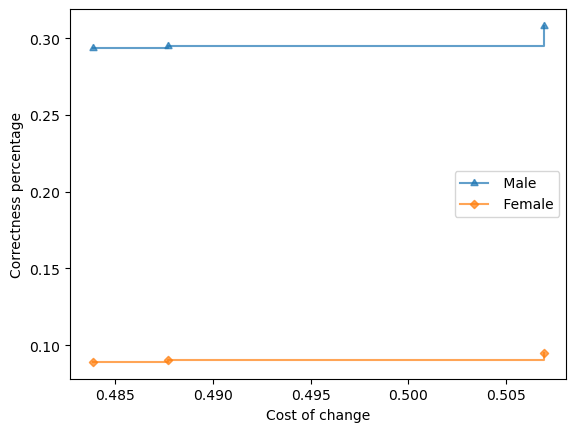

If capital-loss = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 78.55% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 31.06% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 31.23% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 32.60% and counterfactual cost = 0.51.
		Make race =  Black with effectiveness 32.60% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 72.14% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 10.16% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 10.29% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 10.80% and counterfactual cost = 0.51.
		Make race =  Black with effectiveness 10.80% and counterfactual cost = 100.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 9.5.
	Cumulativ

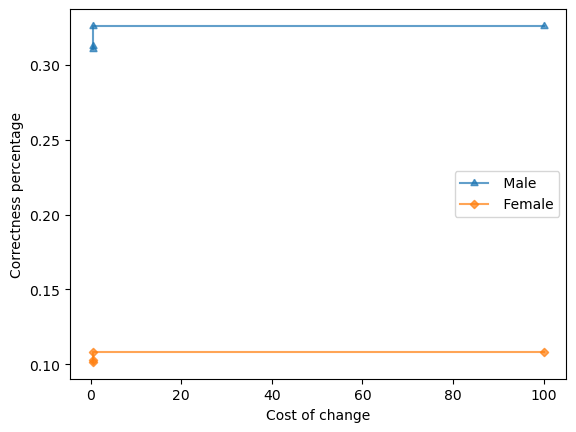

If capital-loss = 0, race =  White:
	Protected Subgroup ' Male', 84.79% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 29.89% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 30.10% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 31.45% and counterfactual cost = 0.51.
		Make race =  Black with effectiveness 31.45% and counterfactual cost = 100.0.
		Make race =  Asian-Pac-Islander with effectiveness 31.45% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 77.46% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 9.98% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 10.10% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 10.61% and counterfactual cost = 0.51.
		Make race =  Black with effectiveness 10.61% and counterfactual cost = 100.0.
		Make race =  Asi

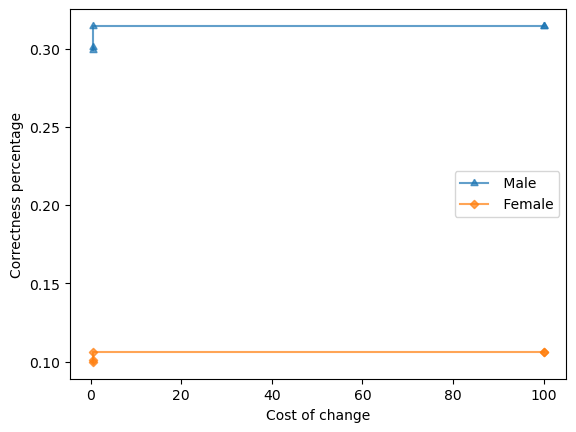

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime:
	Protected Subgroup ' Male', 47.99% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 52.40% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 53.86% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 86.75% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 86.75% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 86.75% and counterfactual cost = 0.49.
		Make hours-per-week = MidTime with effectiveness 86.75% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 86.75% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 86.75% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 86.75% and counterfactual cost = 2.08.
		Make capital

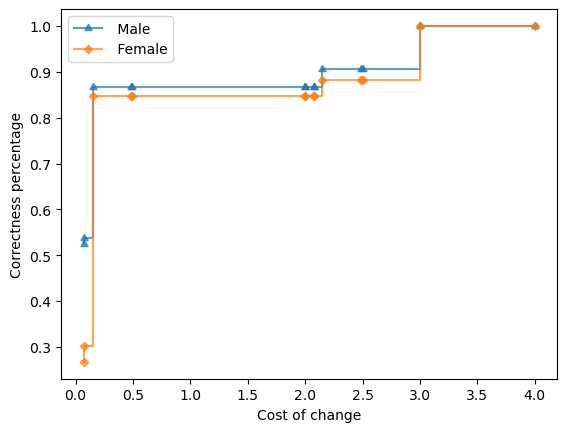

If capital-gain = 0, hours-per-week = FullTime:
	Protected Subgroup ' Male', 49.41% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 53.02% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 54.46% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 87.05% and counterfactual cost = 0.15.
		Make hours-per-week = MidTime with effectiveness 87.05% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 87.05% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 87.05% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 87.05% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 90.81% and counterfactual cost = 2.15.
		Make capital-gain = 99999, hours-per-week = OverTime with effectiveness 100.00% and cou

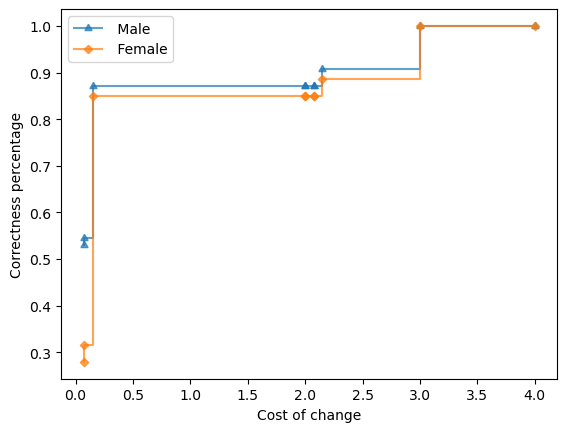

If Workclass =  Private, capital-loss = 0:
	Protected Subgroup ' Male', 72.71% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 26.32% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 26.44% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 27.66% and counterfactual cost = 0.51.
		Make Workclass =  Self-emp-not-inc with effectiveness 27.66% and counterfactual cost = 2.0.
		Make Workclass =  Local-gov with effectiveness 27.66% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 27.66% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 27.66% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 27.66% and counterfactual cost = 2.0.
	Protected Subgroup ' Female', 77.27% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 7.44% and counterfactual 

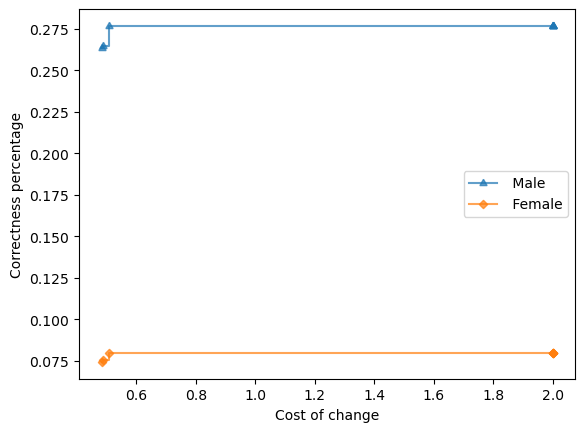

If Workclass =  Private, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 64.91% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 27.47% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 27.58% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 28.74% and counterfactual cost = 0.51.
		Make Workclass =  Local-gov with effectiveness 28.74% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 28.74% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 28.74% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 28.74% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 28.74% and counterfactual cost = 2.0.
	Protected Subgroup ' Female', 70.00% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effect

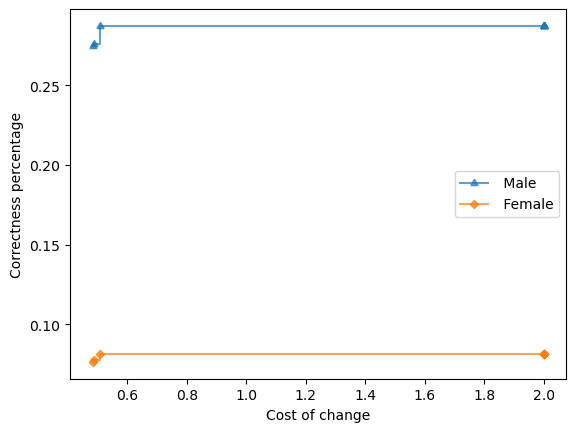

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, native-country =  United-States:
	Protected Subgroup ' Male', 42.77% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 54.00% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 55.56% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 87.61% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 87.61% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 87.61% and counterfactual cost = 0.49.
		Make hours-per-week = MidTime with effectiveness 87.61% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 87.61% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 87.61% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 87.61% and counterfa

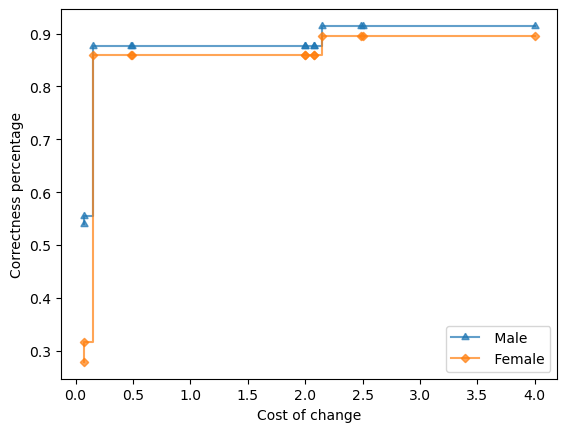

If capital-gain = 0, hours-per-week = FullTime, native-country =  United-States:
	Protected Subgroup ' Male', 44.01% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 54.53% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 56.07% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 87.89% and counterfactual cost = 0.15.
		Make hours-per-week = MidTime with effectiveness 87.89% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 87.89% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 87.89% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 87.89% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 91.68% and counterfactual cost = 2.15.
		Make hours-per-week = BrainDrain with effectiveness 91

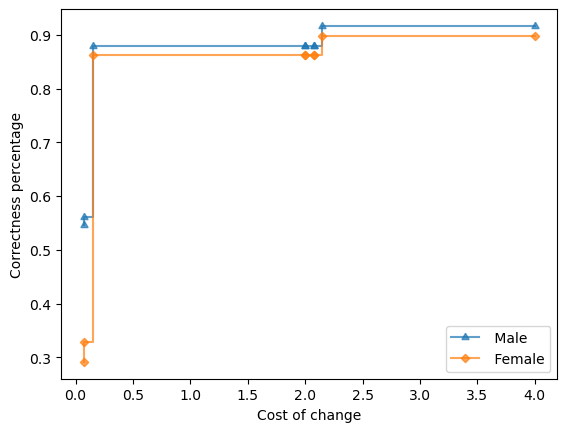

If age = (50.0, 90.0], capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Male', 17.54% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 72.29% and counterfactual cost = 0.07.
		Make capital-gain = 15024 with effectiveness 97.87% and counterfactual cost = 0.15.
	Protected Subgroup ' Female', 15.83% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 31.73% and counterfactual cost = 0.07.
		Make capital-gain = 15024 with effectiveness 90.51% and counterfactual cost = 0.15.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 8.31.
	Cumulative effectiveness plot for the above recourses:


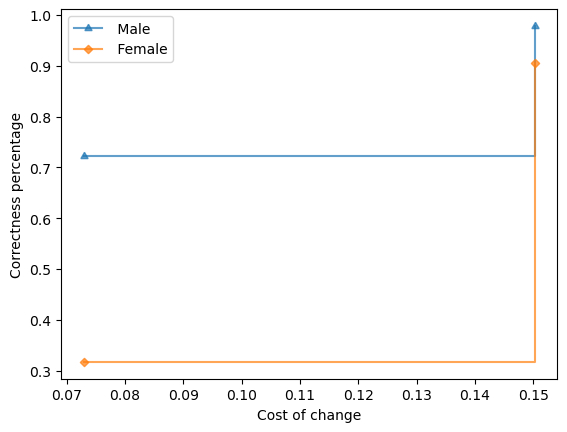

If Workclass =  Private, capital-loss = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 57.74% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 29.39% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 29.51% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 30.70% and counterfactual cost = 0.51.
		Make Workclass =  Self-emp-not-inc with effectiveness 30.70% and counterfactual cost = 2.0.
		Make Workclass =  Local-gov with effectiveness 30.70% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 30.70% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 30.70% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 30.70% and counterfactual cost = 2.0.
		Make race =  Black with effectiveness 30.70% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 57.01

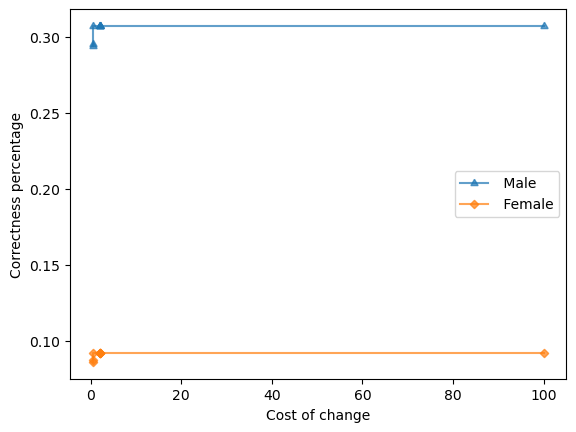

If age = (50.0, 90.0], capital-gain = 0:
	Protected Subgroup ' Male', 18.00% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 72.61% and counterfactual cost = 0.07.
		Make capital-gain = 15024 with effectiveness 97.93% and counterfactual cost = 0.15.
	Protected Subgroup ' Female', 16.21% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 33.13% and counterfactual cost = 0.07.
		Make capital-gain = 15024 with effectiveness 90.85% and counterfactual cost = 0.15.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 8.19.
	Cumulative effectiveness plot for the above recourses:


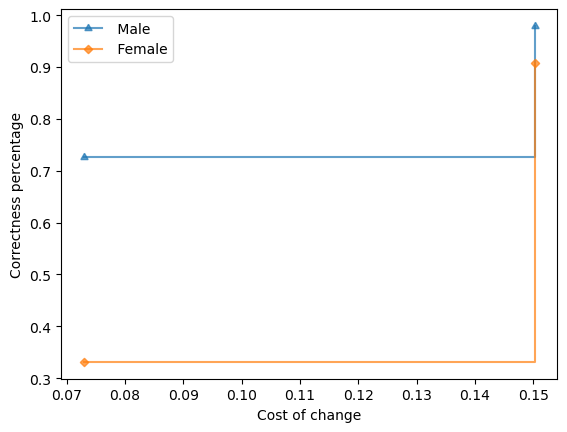

If capital-loss = 0, hours-per-week = FullTime:
	Protected Subgroup ' Male', 49.53% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 27.47% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 27.56% and counterfactual cost = 0.49.
		Make hours-per-week = MidTime with effectiveness 27.56% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 27.56% and counterfactual cost = 2.0.
		Make capital-loss = 1902, hours-per-week = OverTime with effectiveness 36.30% and counterfactual cost = 2.49.
		Make capital-loss = 1977, hours-per-week = OverTime with effectiveness 36.81% and counterfactual cost = 2.51.
		Make hours-per-week = BrainDrain with effectiveness 36.81% and counterfactual cost = 4.0.
	Protected Subgroup ' Female', 46.67% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 8.76% and counterfactual cost = 0.48.
		Make capital-loss

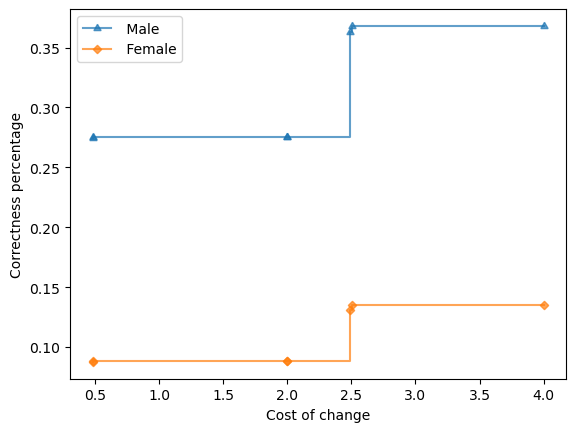

If Workclass =  Private, capital-loss = 0, race =  White:
	Protected Subgroup ' Male', 63.13% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 28.03% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 28.17% and counterfactual cost = 0.49.
		Make capital-loss = 1977 with effectiveness 29.37% and counterfactual cost = 0.51.
		Make Workclass =  Self-emp-not-inc with effectiveness 29.37% and counterfactual cost = 2.0.
		Make Workclass =  Local-gov with effectiveness 29.37% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 29.37% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 29.37% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 29.37% and counterfactual cost = 2.0.
		Make race =  Black with effectiveness 29.37% and counterfactual cost = 100.0.
		Make race =  Asian-Pac-Islander with effectiveness 29.37% and count

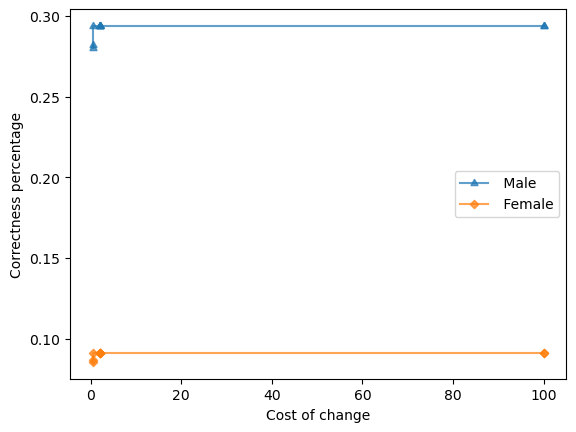

If capital-loss = 0, hours-per-week = FullTime, native-country =  United-States:
	Protected Subgroup ' Male', 44.19% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 28.70% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 28.73% and counterfactual cost = 0.49.
		Make hours-per-week = MidTime with effectiveness 28.73% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 28.73% and counterfactual cost = 2.0.
		Make capital-loss = 1902, hours-per-week = OverTime with effectiveness 37.65% and counterfactual cost = 2.49.
		Make capital-loss = 1977, hours-per-week = OverTime with effectiveness 38.15% and counterfactual cost = 2.51.
		Make hours-per-week = BrainDrain with effectiveness 38.15% and counterfactual cost = 4.0.
	Protected Subgroup ' Female', 41.98% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 9.14% and counterfactual

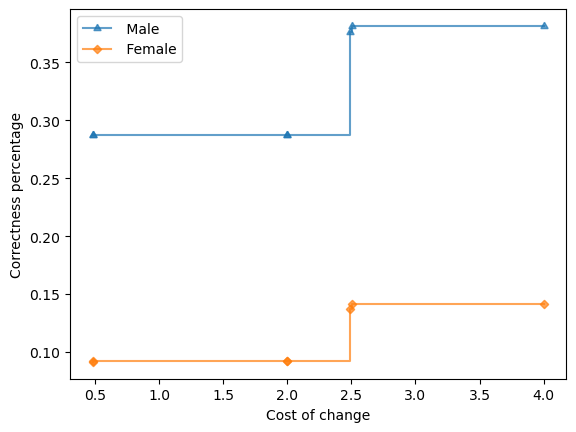

If Workclass =  Private, capital-gain = 0, capital-loss = 0, hours-per-week = FullTime:
	Protected Subgroup ' Male', 38.08% covered (protected subgroup population size not given)
		Make capital-gain = 7688 with effectiveness 50.36% and counterfactual cost = 0.08.
		Make Workclass =  Local-gov with effectiveness 50.36% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 50.36% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 50.36% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 50.36% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 50.36% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 50.36% and counterfactual cost = 2.0.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 54.42% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 89.10% and co

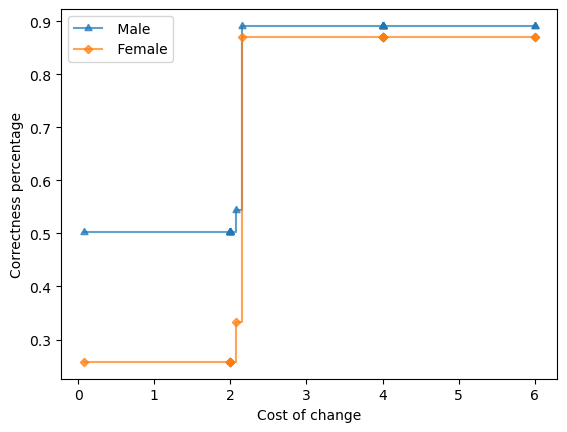

If Workclass =  Private, capital-gain = 0, hours-per-week = FullTime:
	Protected Subgroup ' Male', 39.07% covered (protected subgroup population size not given)
		Make capital-gain = 7688 with effectiveness 51.05% and counterfactual cost = 0.08.
		Make Workclass =  Local-gov with effectiveness 51.05% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 51.05% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 51.05% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 51.05% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 51.05% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 51.05% and counterfactual cost = 2.0.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 55.19% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 89.38% and counterfactual cost 

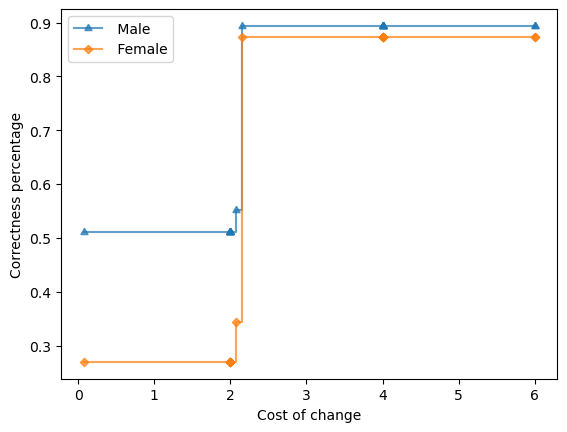

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, race =  White:
	Protected Subgroup ' Male', 40.59% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 54.28% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 55.74% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 87.61% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 87.61% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 87.61% and counterfactual cost = 0.49.
		Make hours-per-week = MidTime with effectiveness 87.61% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 87.61% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 87.61% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 87.61% and counterfactual cost = 2.08.

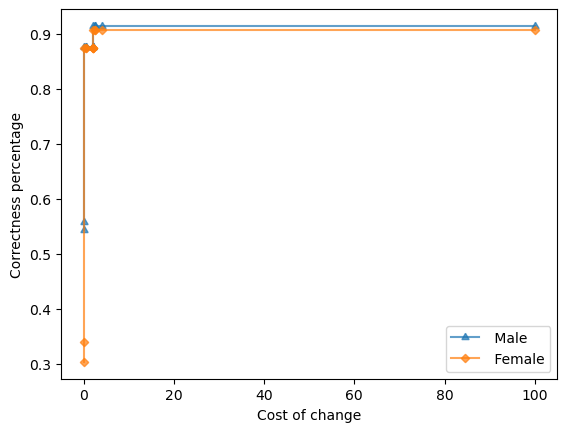

If capital-loss = 0, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 38.30% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 30.76% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 30.80% and counterfactual cost = 0.49.
		Make hours-per-week = MidTime with effectiveness 30.80% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 30.80% and counterfactual cost = 2.0.
		Make capital-loss = 1902, hours-per-week = OverTime with effectiveness 40.43% and counterfactual cost = 2.49.
		Make hours-per-week = BrainDrain with effectiveness 40.43% and counterfactual cost = 4.0.
		Make race =  Black with effectiveness 40.43% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 32.72% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 10.70% and counterfactual cost = 0.48.
		

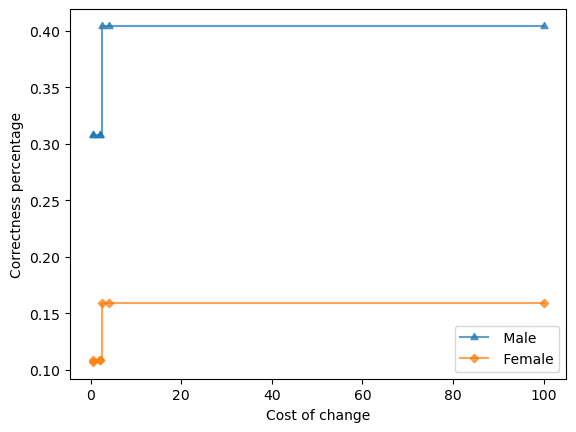

If capital-loss = 0, hours-per-week = FullTime, race =  White:
	Protected Subgroup ' Male', 41.90% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 29.26% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 29.37% and counterfactual cost = 0.49.
		Make hours-per-week = MidTime with effectiveness 29.37% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 29.37% and counterfactual cost = 2.0.
		Make capital-loss = 1902, hours-per-week = OverTime with effectiveness 38.75% and counterfactual cost = 2.49.
		Make capital-loss = 1977, hours-per-week = OverTime with effectiveness 39.14% and counterfactual cost = 2.51.
		Make hours-per-week = BrainDrain with effectiveness 39.14% and counterfactual cost = 4.0.
		Make race =  Black with effectiveness 39.14% and counterfactual cost = 100.0.
		Make race =  Asian-Pac-Islander with effectiveness 39.14% and counterfactual cost = 100.0.
	Protect

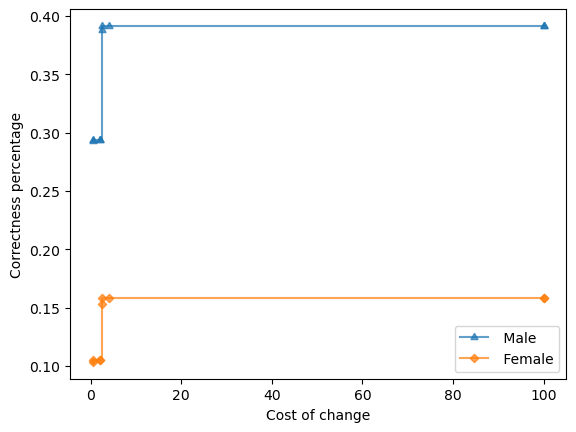

If Workclass =  Private, capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, native-country =  United-States:
	Protected Subgroup ' Male', 33.45% covered (protected subgroup population size not given)
		Make capital-gain = 7688 with effectiveness 52.10% and counterfactual cost = 0.08.
		Make Workclass =  Local-gov with effectiveness 52.10% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 52.10% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 52.10% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 52.10% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 52.10% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 52.10% and counterfactual cost = 2.0.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 56.00% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime

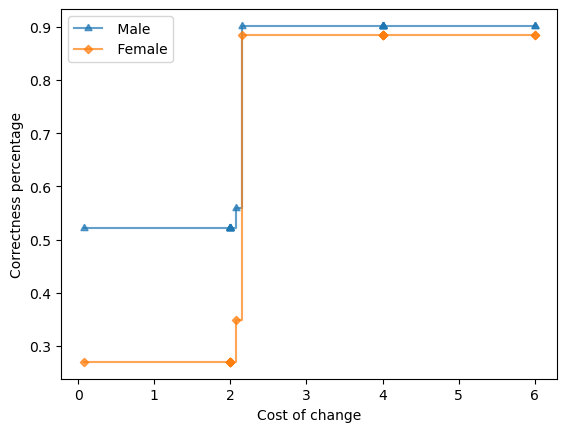

If capital-gain = 0, hours-per-week = FullTime, race =  White:
	Protected Subgroup ' Male', 41.75% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 54.90% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 56.35% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 87.86% and counterfactual cost = 0.15.
		Make hours-per-week = MidTime with effectiveness 87.86% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 87.86% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 87.86% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 87.86% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 91.63% and counterfactual cost = 2.15.
		Make hours-per-week = BrainDrain with effectiveness 91.63% and counterfa

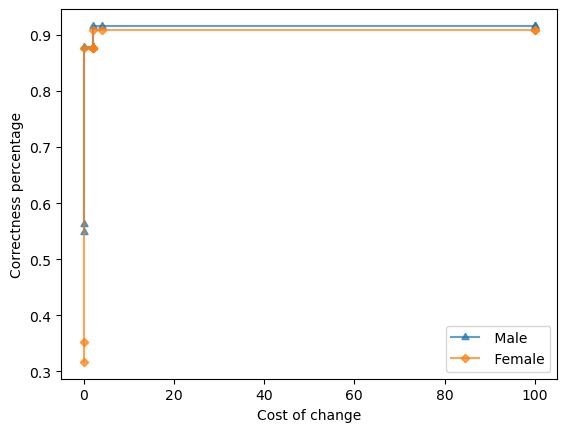

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 37.07% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 56.24% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 57.76% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 88.61% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 88.61% and counterfactual cost = 0.48.
		Make capital-loss = 1902 with effectiveness 88.61% and counterfactual cost = 0.49.
		Make hours-per-week = MidTime with effectiveness 88.61% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 88.61% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 88.61% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 88.61

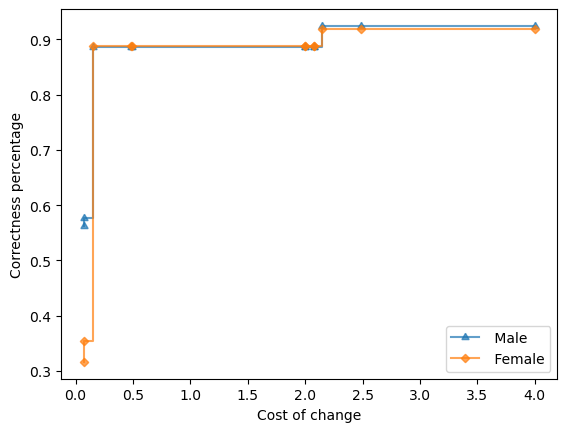

If Workclass =  Private, capital-gain = 0, hours-per-week = FullTime, native-country =  United-States:
	Protected Subgroup ' Male', 34.30% covered (protected subgroup population size not given)
		Make capital-gain = 7688 with effectiveness 52.69% and counterfactual cost = 0.08.
		Make Workclass =  Local-gov with effectiveness 52.69% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 52.69% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 52.69% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 52.69% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 52.69% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 52.69% and counterfactual cost = 2.0.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 56.68% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectivenes

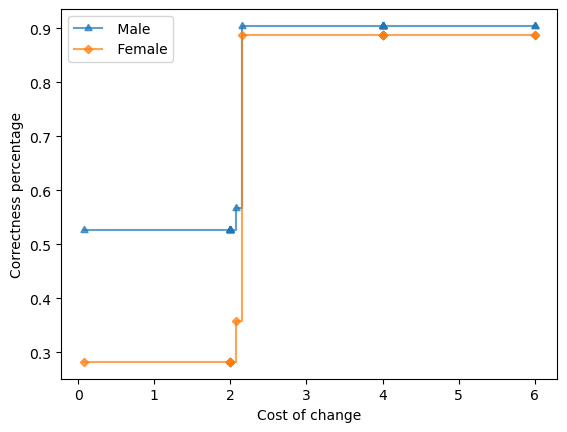

If capital-gain = 0, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 38.15% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 56.77% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 58.29% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 88.83% and counterfactual cost = 0.15.
		Make hours-per-week = MidTime with effectiveness 88.83% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 88.83% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 88.83% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 88.83% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 92.61% and counterfactual cost = 2.15.
		Make hours-per-week = BrainDrain with e

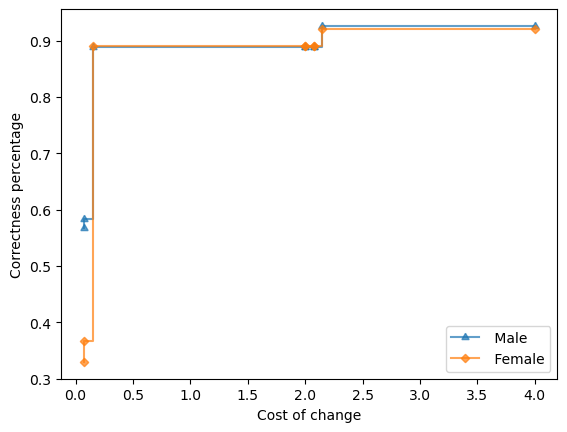

If age = (34.0, 41.0], capital-loss = 0:
	Protected Subgroup ' Male', 17.14% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 3.34% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 6.16% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 49.32% and counterfactual cost = 10.49.
	Protected Subgroup ' Female', 16.65% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 1.22% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 2.91% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 17.13% and counterfactual cost = 10.49.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.67.
	Cumulative effectiveness plot for the above recourses:


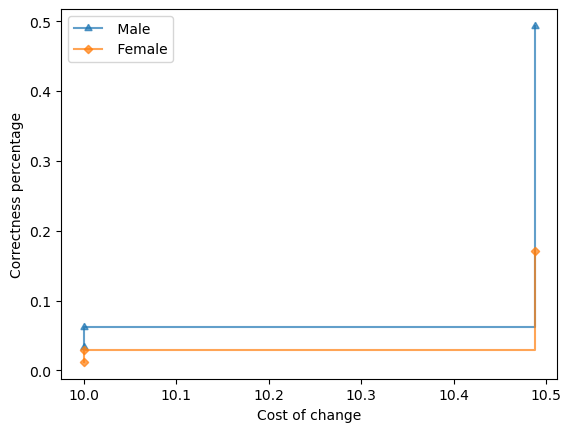

If age = (41.0, 50.0], capital-loss = 0:
	Protected Subgroup ' Male', 14.52% covered (protected subgroup population size not given)
		Make capital-loss = 1902 with effectiveness 49.60% and counterfactual cost = 0.49.
		Make age = (50.0, 90.0] with effectiveness 49.60% and counterfactual cost = 10.0.
	Protected Subgroup ' Female', 15.11% covered (protected subgroup population size not given)
		Make capital-loss = 1902 with effectiveness 15.63% and counterfactual cost = 0.49.
		Make age = (50.0, 90.0] with effectiveness 15.63% and counterfactual cost = 10.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.62.
	Cumulative effectiveness plot for the above recourses:


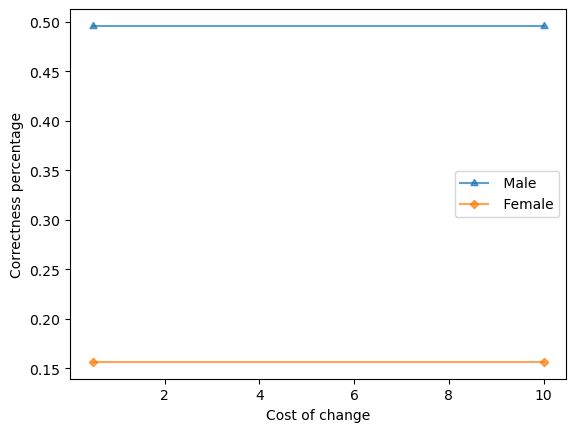

If age = (34.0, 41.0], capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 15.55% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 3.36% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 6.26% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 50.05% and counterfactual cost = 10.49.
	Protected Subgroup ' Female', 15.35% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 1.32% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 2.97% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 17.00% and counterfactual cost = 10.49.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.56.
	Cumulative effectiveness plot for the above recourses:


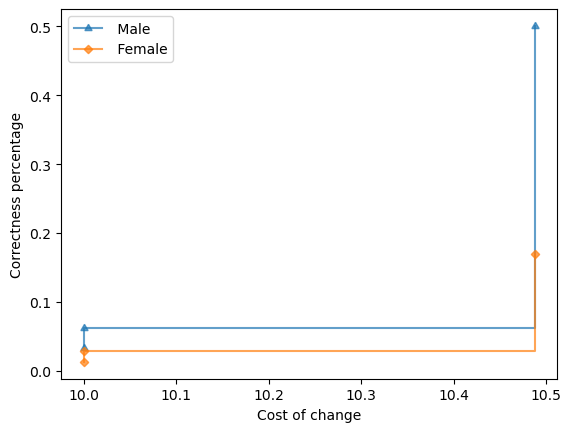

If age = (41.0, 50.0], capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 13.32% covered (protected subgroup population size not given)
		Make capital-loss = 1902 with effectiveness 50.88% and counterfactual cost = 0.49.
		Make age = (50.0, 90.0] with effectiveness 50.88% and counterfactual cost = 10.0.
	Protected Subgroup ' Female', 13.83% covered (protected subgroup population size not given)
		Make capital-loss = 1902 with effectiveness 16.53% and counterfactual cost = 0.49.
		Make age = (50.0, 90.0] with effectiveness 16.53% and counterfactual cost = 10.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.4.
	Cumulative effectiveness plot for the above recourses:


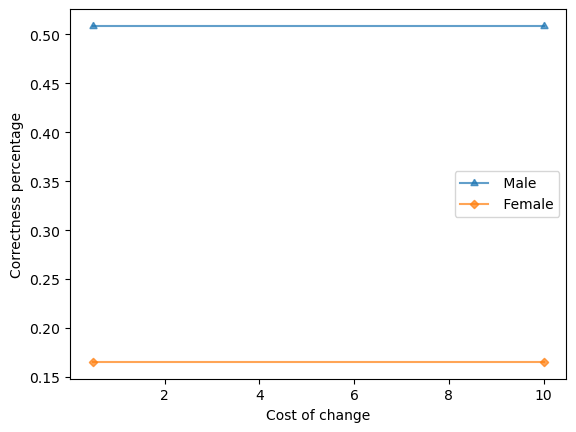

If capital-loss = 0, occupation =  Sales:
	Protected Subgroup ' Male', 10.03% covered (protected subgroup population size not given)
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Protective-serv with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Transport-moving with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Tech-support with effectiveness 5.07% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 12.90% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 16.13% and counterfactual cost = 4.0.
		Make capital-loss = 1902, occupation =  Prof-specialty with effectiveness 42.40% and counterfactual cost = 4.49.
		Make capital-loss = 1977, occupation =  Exec-managerial with effectiveness 44.85% and counterfactual cost 

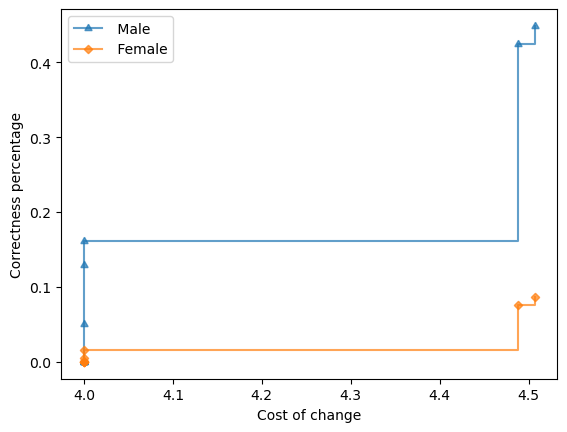

If age = (34.0, 41.0], capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Male', 16.54% covered (protected subgroup population size not given)
		Make capital-gain = 7688 with effectiveness 68.68% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 98.51% and counterfactual cost = 0.15.
		Make age = (50.0, 90.0] with effectiveness 98.51% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 98.51% and counterfactual cost = 10.0.
		Make age = (50.0, 90.0], capital-gain = 7298 with effectiveness 98.51% and counterfactual cost = 10.07.
		Make age = (41.0, 50.0], capital-gain = 7688 with effectiveness 98.51% and counterfactual cost = 10.08.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 98.51% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-gain = 15024 with effectiveness 98.69% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 98.69% and counterf

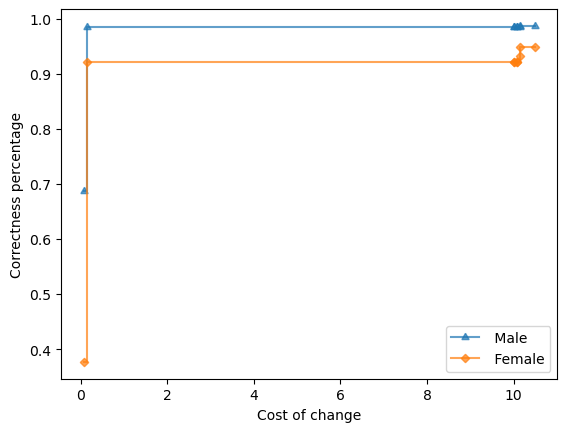

If age = (34.0, 41.0], capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 15.03% covered (protected subgroup population size not given)
		Make capital-gain = 7688 with effectiveness 69.75% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 98.66% and counterfactual cost = 0.15.
		Make age = (50.0, 90.0] with effectiveness 98.66% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 98.66% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-gain = 7688 with effectiveness 98.66% and counterfactual cost = 10.08.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 98.66% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-gain = 15024 with effectiveness 98.85% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 98.85% and counterfactual cost = 10.49.
	Protected Subgroup ' Female', 14.43% covered (prote

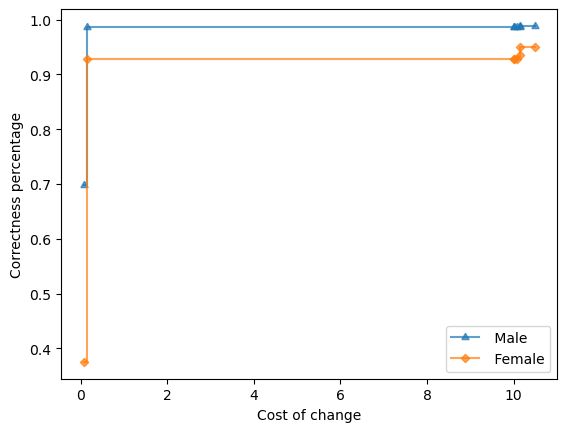

If age = (34.0, 41.0], capital-gain = 0:
	Protected Subgroup ' Male', 17.05% covered (protected subgroup population size not given)
		Make capital-gain = 7688 with effectiveness 68.96% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 98.47% and counterfactual cost = 0.15.
		Make age = (50.0, 90.0] with effectiveness 98.47% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 98.47% and counterfactual cost = 10.0.
		Make age = (50.0, 90.0], capital-gain = 7298 with effectiveness 98.47% and counterfactual cost = 10.07.
		Make age = (41.0, 50.0], capital-gain = 7688 with effectiveness 98.47% and counterfactual cost = 10.08.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 98.47% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-gain = 15024 with effectiveness 98.64% and counterfactual cost = 10.15.
	Protected Subgroup ' Female', 15.97% covered (protected subgroup population size not given)
		Make cap

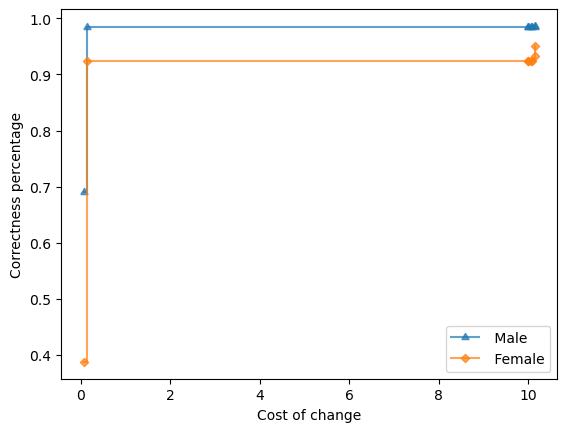

In [18]:
affected_pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}

top_rules,unfairness = facts.select_rules_subset_KStest(
    rules_with_cumulative,
    affected_pop_sizes,
    top_count=50
)

print_recourse_report_KStest_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    unfairness = unfairness,
    show_then_costs=True,
    show_cumulative_plots=True
)

In [19]:
end_time = time.time()

In [20]:
end_time - start_time

40.91109585762024

In [38]:
stats["metrics-time"] = end_time - start_time

In [40]:
stats

{'freq-itemsets-no': {' Female': 28176, ' Male': 27510},
 'inter-groups-no': 13300,
 'unaff-freq-itemsets-no': 57008,
 'valid-if-thens-time': 1237.2908010482788,
 'cumulative-time': 620.324743270874,
 'triples-no': 97413,
 'subgroup-no': 12556,
 'metrics-time': 18.316589832305908}

In [41]:
stats["valid-if-thens-time"] + stats["cumulative-time"] + stats["metrics-time"]

1875.9321341514587